# TOC

* [Plot samples](#Plot-samples)

# LaMassa S82 (x-ray) catalog *versus* UKIDSS

In this notebook the cross-matching procedure applied by [LaMassa et al. 2016] (LM hereafter) to multi-wavelength catalogs will  be reproduced. Particularly, we will cross-match the x-ray data from XMM-Newton AO 13 cycle to UKIDSS near-infrared. The goal here is to verify whether we can recover the very same results therein, showing us our algorithm for Maximum Likelihood Estimator to be correct.

The UKIDSS catalog here in use is the same used in LM: UKIDSS-LAS Data Release 8, *primary* objects, cleaned from spurious/noisy detections; "?*apermag3*" magnitude measurements and accordingly errors were retrieved. The table file `ukidss.fits` here used can be taken from [my github repository][github_ukidss].

The LaMassa catalog --from where we'll take the x-ray sources-- was downloaded from [CDS].

[LaMassa et al. 2016]: http://arxiv.org/abs/1510.00852
[github_ukidss]: https://github.com/chbrandt/uks82
[CDS]: http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J%2FApJ%2F817%2F172

# Maximum Likelihood Estimator (MLE)

MLE is applied by LM to find the correct --or most possible-- counterpart to their x-ray sources. MLE was first proposed by [Sutherland & Saunders in 1992] and is being adopted as a better alternative to the simplistic *nearest-neighbour* algorithm.

What MLE does is to estimate how probable a given counterpart candidate is to be real counterpart from a source in its vicinity. The method was developed having in mind that multiple candidates can be nearby in the (RA,Dec) sky-projected plan. Accordingly, the method includes the ancillary magnitudes as a third component to help differentiating background objects from candidate(s).

Consider the situation where there is a source "S" (which was observed by instrument "A") and in the vicinities, within a distance "da", of S there are $N$ objects ("N1", "N2", ..., "NN") that were observed by a different instrument ("B"). Also observed using "B", but distant a bit further from "S". there are $M$ objects ("M1", "M2", ..., "MM") that can not be related to "S", but will be of our help further on. The "M" objects lie beyond the distance "da" and before distance "db", and $db > da$. *We want now to answer the following question: which of the objects observed by "B" is in fact "S" (observed by a different instrument)?* Before coming with any answer, we are taught that instruments "A" and "B" suffer from different physical effects that lead to uncorrelated errors and different image resolutions when registering the pictures; which means that "S" and its (true) counterpart may *not* be one over the other, but shifted by some amount.

The distance "da" from "S" is considered to be "vicinity", and objects inside this distance are considered, *a priori*, candidates to the (true) counterpart. Such objects will be called *ancillary*  objects. The objects from sample `M` will be called *background* objects, they compose the sample of objects observed by "B" definitely *not* candidate to be "S" counterpart.

The MLE method will eventually give a score called *Reliability* ($R$) to each of the candidates. Such score --reliability-- is the probability of being the true counterpart, and is given by:
$$
R_j = \frac{LR_j}{\sum_j{LR_j}+(1-Q)}
$$

The central figure in MLE is the likelihood ratio, $LR$:
$$
LR_j = \frac{q(m) f(r)}{n(m)}
$$
. 

$f(r)$ is the prior regarding the position of the candidate object relative to the source. Typically, $f(r)$ is modelled as a bidimensional Gaussian with $\sigma$ being the quadrature sum of source's positional error and objects' average positional error:
$$
f(r) = \frac{1}{2 \pi \sigma} exp^{-r^2/2\sigma^2} ; 
$$
$$
\sigma = \frac{1}{2}\Big[\sqrt{\sigma^2_{\alpha_S} + \sigma^2_{\delta_S}} + \sqrt{\sigma^2_{\alpha_O} + \sigma^2_{\delta_O}}\Big]
$$

$q(m)$ is the likelihood of the object being a (good) candidate given its magnitude. It is computed by drawing the ancillary objects normalized magnitude distribution and subtracting from it the normalized background magnitude distribution.

Finally, $n(m)$ is the surface density of background objects with magnitude $m$.It is computed by counting the number of background objects per magnitude bin per square-degree; normalized by the number of objects.


[Sutherland & Saunders in 1992]: http://mnras.oxfordjournals.org/cgi/doi/10.1093/mnras/259.3.413


## The algorithm

Let's put it all together to build an algorithm.

To compute MLE quantities we need to define the background and ancillary samples. 
To do that we have to define the *search radius* ($r_s$) --from where the *ancillary* sample will come out-- and the *inner & outer radii* ($r_i$, $r_o$) for the background sample.

### Search radii

There are different ways to estimate the (best) *search radius*. 
Typically, the instrument's (nominal) error radius, systematic plus statistical, is used, as [LaMassa et al. 2016]. 
[Timlin et al. 2016] have used the Rayleigh Criterion to estimate such radius, considering then a physical limitation on resolving close by objects; similarly, the overall PSF (FWHM) is a valid estimator. 
Another way of estimating $r_s$, data driven, is by directly estimating the typical distance between the objects in each catalog.

Analogously, we have to define the *inner and outer radii*, from the primary source, of the annulus defining the background region. 
Trully speaking, the background region does *not* need to be drawn as an annulus centered centered in the source, but that is a straightforward, generic choice for sampling background sources.
It is important to notice that the background region should avoid other sources' ancillary sample, which is to say that the (annulus) region should not intersect with another source's search area.

* Estimate samples radii
  * (ancillary) search radius: $r_{s}$
  * background (annulus) radii: $r_{i} \lt r_{o}$


### Samples definition

Once we have the radii defined we cross-match the catalogs to define the *ancillary* and *background* samples; At this point, each source has two lists of objects related to it:

* Source
  * ancillary sample (within Rs)
  * background sample (between Ri and Ro)
  
But before looping through each primary source, we may define $q(m)$ and $n(m)$ as they are globally defined functions. And after we have $q(m)$ we may estimate $Q$.

* Estimate magnitude distributions
  * $n(m)$: background surface brightness distribution
  * $q(m)$: ancillary brightness distribution
  * $Q$: expected counterpart recover rate
  
  
#### Radial prior

The radial profile $f(r) \propto \sigma^{-1} \exp^{-r^2/\sigma^2}$ is ideally defined for each source, for $\sigma$ is a function of the source' and ancillary objects' positional errors, $\sigma_s$ and $\sigma_o$, resp.:
$$
\sigma = \sqrt{\frac{\sigma_s^2 + \sigma_o^2}{2}}
$$

If the positional errors are well behaved --i.e, their dispersion is small--, we may approximate $f(r)$ as a global function.
We may consider $\sigma_s$ and $\sigma_o$ as the mean of the respective positional errors.

* Compute mean positional errors
  * primary sources catalog
  * ancillary objects
* define $f(r)$


#### Likelood Ratio threshold

The LR-threshold, $LR_{th}$, is the minimum value an ancillary object may score to be considered a counterpart candidate.
There are different ways to compute $LR_{th}$, the simplest one is based on the reliability parameter in a assintotic case: consider there is only *one* ancillary object within the *search radius* around a source; in this case we would expect such object to be the true source' counterpart.
Considering the Reliability parameter, $R$ a probability score, $R_j=0.5$ is the minimal (reasonable) value for such parameter so that the object can be considered a candidate.
Using the definition of $R$ above we should have:
$$
0.5 = \frac{LR_{th}}{LR_{th} + (1-Q)}
$$

$$
LR_{th} = \frac{0.5(Q-1)}{-0.5}
$$

$$
LR_{th} = 1-Q
$$


### Counterpart evaluation

Now that we have all the ingredients in place we may visit each primary source' neighbourhood and evaluate each ancillary object.

For each source,
* Loop over the respective ancillary sample:
  * evaluate each object's $LR$
  * remove objects with $LR_j < LR_{th}$
* Sum all ancillaries' $LR_j$
* Loop over all candidates:
  * compute $R_j$
  
The highest $R_j$ is said to be the true counterpart.





[Timlin et al. 2016]: http://arxiv.org/abs/1603.08488

# Coding

## Read X-ray and IR catalogs

In [1]:
import booq
from booq import table

### X-Ray (Lamassa-XMM-AO13)

In [2]:
tab_lm = table.ATable.read('lamassa/cds/xmmao13.dat',readme='lamassa/cds/ReadMe',format='cds')

In [3]:
df_lm = tab_lm.to_dataframe()
del tab_lm
df_lm.head()

,Seq,ObsID,RAdeg,DEdeg,e_Pos,DistNN,ExtFlag,InXMM,InChandra,FSoft,...,rH,F250,e_F250,F350,e_F350,F500,e_F500,XMMAO10CP,ChCP,CPCoord
0,2359.0,742830101.0,14.097,0.166,4.7,515.8,0.0,no,no,1.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2360.0,742830101.0,14.115,-0.353,3.5,171.7,0.0,no,no,1.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2361.0,742830101.0,14.115,-0.160,5.8,291.7,0.0,no,no,2.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2362.0,742830101.0,14.142,-0.442,3.4,49.1,0.0,no,no,0.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2363.0,742830101.0,14.154,-0.448,2.1,49.1,0.0,no,no,7.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [4]:
ID_column_lm = 'Seq'
df_lm[ID_column_lm] = df_lm[ID_column_lm].astype(int).astype(str)

df_lm.head()

,Seq,ObsID,RAdeg,DEdeg,e_Pos,DistNN,ExtFlag,InXMM,InChandra,FSoft,...,rH,F250,e_F250,F350,e_F350,F500,e_F500,XMMAO10CP,ChCP,CPCoord
0,2359,742830101.0,14.097,0.166,4.7,515.8,0.0,no,no,1.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2360,742830101.0,14.115,-0.353,3.5,171.7,0.0,no,no,1.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2361,742830101.0,14.115,-0.160,5.8,291.7,0.0,no,no,2.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2362,742830101.0,14.142,-0.442,3.4,49.1,0.0,no,no,0.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2363,742830101.0,14.154,-0.448,2.1,49.1,0.0,no,no,7.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### IR (UKIDSS-DR8)

In [5]:
from booq.io import fits
uk = fits.open('ukidss/ukidss.fits')
uk.info


  file: ukidss/ukidss.fits
  extension: 1
  type: BINARY_TBL
  rows: 3501552
  column info:
    SOURCEID            i8  
    RA                  f8  
    DEC                 f8  
    SIGRA               f4  
    SIGDEC              f4  
    EPOCH               f8  
    EBV                 f4  
    AY                  f4  
    AJ                  f4  
    AH                  f4  
    AK                  f4  
    MERGEDCLASS         i2  
    MERGEDCLASSSTAT     f4  
    YHALLMAG            f4  
    YHALLMAGERR         f4  
    YPETROMAG           f4  
    YPETROMAGERR        f4  
    YPSFMAG             f4  
    YPSFMAGERR          f4  
    YAPERMAG3           f4  
    YAPERMAG3ERR        f4  
    J_1HALLMAG          f4  
    J_1HALLMAGERR       f4  
    J_1PETROMAG         f4  
    J_1PETROMAGERR      f4  
    J_1PSFMAG           f4  
    J_1PSFMAGERR        f4  
    J_1APERMAG3         f4  
    J_1APERMAG3ERR      f4  
    HHALLMAG            f4  
    HHALLMAGERR         f4  
    HPET

In [6]:
# cat_uk = table.read('ukidss/ukidss.fits',
#                     columns=['SOURCEID','RA','DEC','SIGRA','SIGDEC',
#                              'YAPERMAG3','J_1APERMAG3','HAPERMAG3','KAPERMAG3']
#                    )
# cat_uk['SOURCEID'] = cat_uk['SOURCEID'].astype(int).astype(str)

In [7]:
from booq import table
tab_uk_pos = table.ATable.read('ukidss/ukidss.fits',columns=['RA','DEC'])
#TODO: at init/reading be able to specific specific region(s) to load
#cat_uk = table.ATable.read('ukidss/ukidss.fits',conesearch=(ra,dec,radius),
#                          columns={'ra':'RA2000','dec':'DE2000'})
#cat_uk = table.ATable.read('ukidss/ukidss.fits',around=(cat_lm,radius),
#                          columns={'ra':'RA2000','dec':'DE2000'})
#cat_uk = table.ATable.read('ukidss/ukidss.fits',region=booq.region.Region,
#                          columns={'ra':'RA2000','dec':'DE2000'})

In [8]:
df_uk_pos = tab_uk_pos.to_dataframe()
del tab_uk_pos
df_uk_pos.head()

,RA,DEC
0,6.021207,0.021641
1,6.022647,0.021643
2,6.021880,0.021649
3,6.021893,0.021659
4,6.022186,0.021660


**For some reason, UKIDSS positional columns (RA,Dec) are in radians; transform to degrees**

In [9]:
from astropy.coordinates import Angle
ra = Angle(df_uk_pos['RA'].values,'rad').to('deg')
dec= Angle(df_uk_pos['DEC'].values,'rad').to('deg')
df_uk_pos['RA'] = ra
df_uk_pos['DEC'] = dec

df_uk_pos.describe()

                 RA           DEC
count  3.501552e+06  3.501552e+06
mean   1.841558e+02 -3.185555e-02
std    1.530424e+02  7.262582e-01
min    1.004211e-05 -1.249998e+00
25%    3.243559e+01 -6.691321e-01
50%    3.134817e+02 -5.326323e-02
75%    3.349581e+02  6.023953e-01
max    3.600000e+02  1.250000e+00

Total number of rows: 3501552 (3.5e+06)

-> Has Nil? (How many?)
RA     0
DEC    0
dtype: int64


#### Define a sub sample

Because the UKIDSS catalog is quite big, we should define a sub-sample to better explorer the data.

In [10]:
ra_min = df_lm.RAdeg.min() - 0.5
ra_max = df_lm.RAdeg.max() + 0.5
dec_min = df_lm.DEdeg.min() - 0.1
dec_max = df_lm.DEdeg.max() + 0.1
df_uk_sample = df_uk_pos.crop(RA=(ra_min,ra_max),
                           DEC=(dec_min,dec_max))
del df_uk_pos

df_uk_sample.describe()

                  RA            DEC
count  231338.000000  231338.000000
mean       21.215457       0.013751
std         4.365869       0.389857
min        13.597006      -0.721999
25%        17.474631      -0.301291
50%        21.748381       0.031961
75%        24.765722       0.342271
max        28.543990       0.703997

Total number of rows: 231338 (2.3e+05)

-> Has Nil? (How many?)
RA     0
DEC    0
dtype: int64


In [11]:
df_uk_sample.head()

,RA,DEC
601783,23.367877,0.687888
601784,23.460531,0.688232
601785,23.414002,0.687667
601786,23.280570,0.687302
601787,23.474184,0.687547


Now we get the positional-index of those selected lines to load the whole UKIDSS catalog.

In [12]:
# 'rows' contains the positions of our interest (the ones in df_uk_sample aget df_uk)
rows = df_uk_sample.index.values
del df_uk_sample

tab_uk_sample = table.ATable.read('ukidss/ukidss.fits',rows=rows)
tab_uk_sample

SOURCEID,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,AK,MERGEDCLASS,MERGEDCLASSSTAT,YHALLMAG,YHALLMAGERR,YPETROMAG,YPETROMAGERR,YPSFMAG,YPSFMAGERR,YAPERMAG3,YAPERMAG3ERR,J_1HALLMAG,J_1HALLMAGERR,J_1PETROMAG,J_1PETROMAGERR,J_1PSFMAG,J_1PSFMAGERR,J_1APERMAG3,J_1APERMAG3ERR,HHALLMAG,HHALLMAGERR,HPETROMAG,HPETROMAGERR,HPSFMAG,HPSFMAGERR,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
int64,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
433827929919,0.407846390194,0.0120059039264,-9.99999e+08,-9.99999e+08,2005.90215116,0.0220508,0.0267036,0.0196032,0.0127454,0.0079383,1,4.93475,19.8162,0.339393,19.7927,0.352423,-9.99999e+08,-9.99999e+08,19.6622,0.129669,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,18.5194,0.341595,18.6227,0.444583,-9.99999e+08,-9.99999e+08,18.5062,0.151259,16.8393,0.166297,17.0132,0.244477,-9.99999e+08,-9.99999e+08,17.5441,0.124013
433827929920,0.409463516869,0.012011917063,-9.99999e+08,-9.99999e+08,2005.90215116,0.0236491,0.028639,0.021024,0.0136692,0.00851367,-1,0.421079,17.9835,0.0401669,17.9463,0.0584219,-9.99999e+08,-9.99999e+08,17.8783,0.0279219,17.4947,0.0500438,17.5421,0.0748066,-9.99999e+08,-9.99999e+08,17.3798,0.0304339,16.9268,0.0543857,16.9449,0.0858596,-9.99999e+08,-9.99999e+08,16.8934,0.035704,16.618,0.0808161,16.6613,0.118318,-9.99999e+08,-9.99999e+08,16.5653,0.0519861
433827929921,0.408651420325,0.0120020568056,-9.99999e+08,-9.99999e+08,2005.90215116,0.0226826,0.0274686,0.0201648,0.0131105,0.00816573,1,2.94201,19.834,0.366881,19.834,0.366881,-9.99999e+08,-9.99999e+08,20.2877,0.228542,19.2812,0.234339,19.2812,0.234339,-9.99999e+08,-9.99999e+08,19.6216,0.228677,18.7383,0.383572,18.7283,0.389533,-9.99999e+08,-9.99999e+08,18.6331,0.170696,17.6925,0.398679,17.6925,0.398679,-9.99999e+08,-9.99999e+08,17.7641,0.152736
433827929922,0.406322596785,0.0119956787088,-9.99999e+08,-9.99999e+08,2005.90215116,0.0225056,0.0272542,0.0200075,0.0130082,0.00810201,1,16.0753,17.4584,0.0395172,17.2767,0.0590367,-9.99999e+08,-9.99999e+08,17.841,0.0268707,16.9499,0.0415769,16.7474,0.0635827,-9.99999e+08,-9.99999e+08,17.2757,0.0275967,16.1115,0.0399464,16.0146,0.0600487,-9.99999e+08,-9.99999e+08,16.5572,0.0260672,15.3375,0.0384352,15.0854,0.0602332,-9.99999e+08,-9.99999e+08,15.8079,0.0255751
433827929923,0.409701804291,0.0119999505893,-9.99999e+08,-9.99999e+08,2005.90215116,0.0239274,0.0289761,0.0212715,0.0138301,0.00861388,1,0.782843,20.1834,0.387817,20.1834,0.387817,-9.99999e+08,-9.99999e+08,20.3265,0.239728,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08,-9.99999e+08
433827929924,0.409192913378,0.0120002894351,-9.99999e+08,-9.99999e+08,2005.90215116,0.0233148,0.0282342,0.0207268,0.0134759,0.00839331,1,15.8572,18.3361,0.11912,18.4298,0.200747,-9.99999e+08,-9.99999e+08,18.941,0.0686888,17.7032,0.105149,17.7141,0.127878,-9.99999e+08,-9.99999e+08,18.4453,0.0785382,17.0186,0.134257,17.1364,0.218883,-9.99999e+08,-9.99999e+08,17.5933,0.0666682,16.3074,0.130962,16.4882,0.237619,-9.99999e+08,-9.99999e+08,16.8477,0.0668407
433827929925,0.407144874736,0.0119879010813,-9.99999e+08,-9.99999e+08,2005.90215116,0.0219588,0.0265921,0.0195214,0.0126922,0.00790517,1,10.203,18.5988,0.166848,18.6272,0.239986,-9.99999e+08,-9.99999e+08,19.2887,0.0926362,18.2093,0.111538,18.1836,0.116781,-9.99999e+08,-9.99999e+08,19.0402,0.133803,17.1965,0.157632,17.3195,0.225639,-9.99999e+08,-9.99999e+08,1

In [13]:
df_uk = tab_uk_sample.to_dataframe()
del tab_uk_sample

from astropy.coordinates import Angle
ra = Angle(df_uk['RA'].values,'rad').to('deg')
dec= Angle(df_uk['DEC'].values,'rad').to('deg')
df_uk['RA'] = ra
df_uk['DEC'] = dec

df_uk.describe()

           SOURCEID             RA            DEC        SIGRA       SIGDEC  \
count  2.313380e+05  231338.000000  231338.000000     231338.0     231338.0   
mean   4.338322e+11      21.215457       0.013751 -999999488.0 -999999488.0   
std    2.958270e+06       4.365869       0.389857          0.0          0.0   
min    4.338279e+11      13.597006      -0.721999 -999999488.0 -999999488.0   
25%    4.338291e+11      17.474631      -0.301291 -999999488.0 -999999488.0   
50%    4.338325e+11      21.748381       0.031961 -999999488.0 -999999488.0   
75%    4.338345e+11      24.765722       0.342271 -999999488.0 -999999488.0   
max    4.338373e+11      28.543990       0.703997 -999999488.0 -999999488.0   

               EPOCH            EBV             AY             AJ  \
count  231338.000000  231338.000000  231338.000000  231338.000000   
mean     2006.341197       0.032063       0.038828       0.028504   
std         0.630836       0.005339       0.006466       0.004747   
min      200

#### Clean table null values

I assume every negative value in *semi-positive* columns to be `Null/NaN`.
Such columns are the positional (RA,Dec) standard deviations and the magnitude columns.
(Physically speaking, magnitudes are/can be negative; It just does not happen in our case --galaxies.)

In [14]:
cols = ['SIGRA','SIGDEC']
cols.extend( [ c for c in df_uk.filter(like='MAG',axis=1).columns ] )
for col in cols:
    idx = df_uk[col] < 0
    df_uk.loc[idx,col] = None

In [15]:
ID_column_uk = 'SOURCEID'
df_uk[ID_column_uk] = df_uk[ID_column_uk].astype(int).astype(str)

df_uk.head()

,SOURCEID,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
0,433827929919,23.367877,0.687888,NaN,NaN,2005.902151,0.022051,0.026704,0.019603,0.012745,...,18.506187,0.151259,16.839336,0.166297,17.013243,0.244477,NaN,NaN,17.544065,0.124013
1,433827929920,23.460531,0.688232,NaN,NaN,2005.902151,0.023649,0.028639,0.021024,0.013669,...,16.893356,0.035704,16.618038,0.080816,16.661270,0.118318,NaN,NaN,16.565256,0.051986
2,433827929921,23.414002,0.687667,NaN,NaN,2005.902151,0.022683,0.027469,0.020165,0.013111,...,18.633087,0.170696,17.692490,0.398679,17.692490,0.398679,NaN,NaN,17.764069,0.152736
3,433827929922,23.280570,0.687302,NaN,NaN,2005.902151,0.022506,0.027254,0.020007,0.013008,...,16.557207,0.026067,15.337543,0.038435,15.085359,0.060233,NaN,NaN,15.807901,0.025575
4,433827929923,23.474184,0.687547,NaN,NaN,2005.902151,0.023927,0.028976,0.021271,0.013830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot table distributions

In [16]:
# from bokeh.io import output_notebook
# output_notebook()

In [17]:
# from booq.plot import PlotHisto
# p = PlotHisto()
# for col in ['YAPERMAG3','J_1APERMAG3','HAPERMAG3','KAPERMAG3']:
#     ds_label = p.add_dataset(df_uk,label=col,x=col)
#     p.plot(ds_label)
# p.show()

In [18]:
# from booq.plot import PlotHisto
# p = PlotHisto()
# for col in ['YAPERMAG3','J_1APERMAG3','HAPERMAG3','KAPERMAG3']:
#     ds_label = p.add_dataset(df_uk_sample,label=col,x=col)
#     p.plot(ds_label)
# p.show()

### Plot sky distribution

In [19]:
# from booq.plot import PlotScatter
# scatter = PlotScatter()

# # uk_label = scatter.add_dataset(cat_uk,x='RA',y='DEC',label='scatter_uk')
# # scatter.plot(uk_label)

# uks_label = scatter.add_dataset(df_uk,x='RA',y='DEC',label='scatter_uk_sample')
# scatter.plot(uks_label)

# lm_label = scatter.add_dataset(df_lm,x='RAdeg',y='DEdeg',label='scatter_lm')
# scatter.plot(lm_label)

# scatter.show()

### Radii definition

In [20]:
from sklearn.neighbors import NearestNeighbors

X = df_uk[['RA','DEC']].values
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances_uk, indices_uk = nbrs.kneighbors(X)
distances_uk = distances_uk.transpose()

In [21]:
X = df_lm[['RAdeg','DEdeg']].values
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances_lm, indices_lm = nbrs.kneighbors(X)
distances_lm = distances_lm.transpose()

In [22]:
# from booq.plot import PlotHisto
# p = PlotHisto()
# ds_label = p.add_dataset(distances_uk,label='1st-neighbour ukidss',x=1)
# p.plot(ds_label)
# ds_label = p.add_dataset(distances_lm,label='1st-neighbour lamassa',x=1)
# p.plot(ds_label)
# p.show()

##### Nearest neighbours

Let's take the nearest neighbours plot above as a guide to define the search radii when cross-matching. The typical distance among "LaMassa" (x-ray) sources -- *i.e.*, the peak of the distribution, is around 90 arcsec; beggining at $\approx 30"$. On "UKIDSS", if we consider the first peak, it is around $7.2"$.

We may then take $r_s = 7 arcsec$ as the search radius. If we sextuple this radius, the corresponding circle area would be 36 times bigger; we may consider such radius as the background area outer radius. By defining the inner and outer radii as $r_i = 7"$ and $r_o = 42 arcsec$ the annular region is 35 times the ancillary area, which should give us a good background sample.

In [23]:
from astropy.units import arcsec

rs = 7 * arcsec
ri = rs
ro = 6 * ri

### Cross-Match

Defined the corresponding radii for ancillary and background samples search, we proceed now with the corresponding cross-matchings as the first step of samples definition.

In [24]:
from booq.pipelines.xmatch import xmatch
import warnings
warnings.filterwarnings(action='ignore')

#### Ancillary cross-matching

In [25]:
match_ancillary = xmatch(df_lm, df_uk,
                         columns_A=dict(ra='RAdeg',dec='DEdeg',id=ID_column_lm),
                         columns_B=dict(ra='RA',dec='DEC',id=ID_column_uk),
                         method='gc',radius=rs)
match_ancillary.head()

A                                                                   \
    Seq        ObsID   RAdeg  DEdeg e_Pos DistNN ExtFlag InXMM InChandra   
0  2359  742830101.0  14.097  0.166   4.7  515.8     0.0    no        no   
1  2360  742830101.0  14.115 -0.353   3.5  171.7     0.0    no        no   
2  2361  742830101.0  14.115 -0.160   5.8  291.7     0.0    no        no   
3  2362  742830101.0  14.142 -0.442   3.4   49.1     0.0    no        no   
4  2363  742830101.0  14.154 -0.448   2.1   49.1     0.0    no        no   

                ...                   B                                  \
  FSoft         ...         KHALLMAGERR  KPETROMAG KPETROMAGERR KPSFMAG   
0  1.61         ...                 NaN        NaN          NaN     NaN   
1  1.68         ...            0.031406  15.165094     0.047093     NaN   
2  2.02         ...            0.234180  17.763853     0.258605     NaN   
3  0.95         ...            0.112740  16.943735     0.177616     NaN   
4  7.25         ...            0.049313  15.984794     0.066120     NaN   

                                             AB                \
  KPSFMAGERR  KAPERMAG3 KAPERMAG3ERR separation    duplicates   
0        NaN        NaN          NaN        NaN           NaN   
1        NaN  15.644726     0.019929   2.558296          None   
2        NaN  17.884663     0.145093   0.738626  433834423638   
3        NaN  17.142780     0.078272   6.797695          None   
4        NaN  16.248377     0.034981   3.585183          None   

                       
            distances  
0                 NaN  
1                None  
2  5.6150290842272454  
3                None  
4                None  

[5 rows x 169 columns]

In [26]:
match_ancillary.describe()

           A                                                       \
         Seq         ObsID        RAdeg        DEdeg        e_Pos   
count   2862  2.862000e+03  2862.000000  2862.000000  2862.000000   
unique  2862           NaN          NaN          NaN          NaN   
top     3111           NaN          NaN          NaN          NaN   
freq       1           NaN          NaN          NaN          NaN   
mean     NaN  7.466381e+08    20.942283    -0.064055     2.985814   
std      NaN  1.720502e+06     4.334022     0.292446     0.928504   
min      NaN  7.428301e+08    14.097000    -0.622000     0.400000   
25%      NaN  7.473901e+08    17.102750    -0.322750     2.400000   
50%      NaN  7.474001e+08    19.970000    -0.065500     2.900000   
75%      NaN  7.474301e+08    25.257250     0.170750     3.500000   
max      NaN  7.474401e+08    28.044000     0.604000    11.500000   

                                                               \
             DistNN      ExtFlag InXM

**We may remove non-matching sources.** 
They are of no value on building the ancillary sample.
Notice that the reasons why they have not matched can be various.
Of real (scientific) value would be to have **no** counterpart -- that would tell us something about the physical nature of such sources.
But the lack of matching objects can be also a void space in the ancillary catalog, there are regions where UKIDSS has no coverage -- and that is a *false* lack of counterparts.

That said, may remove the non-matching sources, but we must apply the same cleaning to the *background* matching results. So we'll have a fair pair of ancillary and background samples.

In [27]:
match_ancillary = match_ancillary.loc[~match_ancillary.loc[:,('AB','separation')].isnull()]
match_ancillary.head()

A                                                                   \
    Seq        ObsID   RAdeg  DEdeg e_Pos DistNN ExtFlag InXMM InChandra   
1  2360  742830101.0  14.115 -0.353   3.5  171.7     0.0    no        no   
2  2361  742830101.0  14.115 -0.160   5.8  291.7     0.0    no        no   
3  2362  742830101.0  14.142 -0.442   3.4   49.1     0.0    no        no   
4  2363  742830101.0  14.154 -0.448   2.1   49.1     0.0    no        no   
6  2365  742830101.0  14.162  0.038   4.0  224.1     0.0    no        no   

                ...                   B                                  \
  FSoft         ...         KHALLMAGERR  KPETROMAG KPETROMAGERR KPSFMAG   
1  1.68         ...            0.031406  15.165094     0.047093     NaN   
2  2.02         ...            0.234180  17.763853     0.258605     NaN   
3  0.95         ...            0.112740  16.943735     0.177616     NaN   
4  7.25         ...            0.049313  15.984794     0.066120     NaN   
6  1.64         ...            0.169763  17.494886     0.185832     NaN   

                                             AB                \
  KPSFMAGERR  KAPERMAG3 KAPERMAG3ERR separation    duplicates   
1        NaN  15.644726     0.019929   2.558296          None   
2        NaN  17.884663     0.145093   0.738626  433834423638   
3        NaN  17.142780     0.078272   6.797695          None   
4        NaN  16.248377     0.034981   3.585183          None   
6        NaN  17.446341     0.103341   5.428978          None   

                       
            distances  
1                None  
2  5.6150290842272454  
3                None  
4                None  
6                None  

[5 rows x 169 columns]

In [28]:
match_ancillary.describe()

           A                                                       \
         Seq         ObsID        RAdeg        DEdeg        e_Pos   
count   1481  1.481000e+03  1481.000000  1481.000000  1481.000000   
unique  1481           NaN          NaN          NaN          NaN   
top     3684           NaN          NaN          NaN          NaN   
freq       1           NaN          NaN          NaN          NaN   
mean     NaN  7.465086e+08    20.866885    -0.034976     2.844227   
std      NaN  1.827515e+06     4.354893     0.287542     0.907481   
min      NaN  7.428301e+08    14.115000    -0.617000     0.400000   
25%      NaN  7.473901e+08    17.016000    -0.282000     2.300000   
50%      NaN  7.474001e+08    19.871000    -0.028000     2.800000   
75%      NaN  7.474301e+08    25.148000     0.189000     3.400000   
max      NaN  7.474401e+08    28.044000     0.604000     7.300000   

                                                               \
             DistNN      ExtFlag InXM

In [29]:
# non_matching_ancillary = match_ancillary.loc[match_ancillary.loc[:,('AB','dist')].isnull()]
# non_matching_ancillary.describe()

#### Background cross-matching

In [30]:
match_background = xmatch(df_lm, df_uk,
                         columns_A=dict(ra='RAdeg',dec='DEdeg',id=ID_column_lm),
                         columns_B=dict(ra='RA',dec='DEC',id=ID_column_uk),
                         method='gc',radius=ro)
match_background.head()

A                                                                   \
    Seq        ObsID   RAdeg  DEdeg e_Pos DistNN ExtFlag InXMM InChandra   
0  2359  742830101.0  14.097  0.166   4.7  515.8     0.0    no        no   
1  2360  742830101.0  14.115 -0.353   3.5  171.7     0.0    no        no   
2  2361  742830101.0  14.115 -0.160   5.8  291.7     0.0    no        no   
3  2362  742830101.0  14.142 -0.442   3.4   49.1     0.0    no        no   
4  2363  742830101.0  14.154 -0.448   2.1   49.1     0.0    no        no   

                               ...                                   B  \
  FSoft                        ...                         KHALLMAGERR   
0  1.61                        ...                            0.212726   
1  1.68                        ...                            0.031406   
2  2.02                        ...                            0.234180   
3  0.95                        ...                            0.112740   
4  7.25                        ...                            0.049313   

                                                                      \
   KPETROMAG KPETROMAGERR KPSFMAG KPSFMAGERR  KAPERMAG3 KAPERMAG3ERR   
0  17.259270     0.266500     NaN        NaN  17.693806     0.135874   
1  15.165094     0.047093     NaN        NaN  15.644726     0.019929   
2  17.763853     0.258605     NaN        NaN  17.884663     0.145093   
3  16.943735     0.177616     NaN        NaN  17.142780     0.078272   
4  15.984794     0.066120     NaN        NaN  16.248377     0.034981   

          AB                                                     \
  separation                                         duplicates   
0   8.145277  433830679408;433830679023;433830678980;4338306...   
1   2.558296             433834423106;433834423147;433834423635   
2   0.738626  433834423127;433834423131;433834423632;4338344...   
3   6.797695  433836362985;433836362987;433836362444;4338363...   
4   3.585183  433836362503;433836363001;433836362478;4338363...   

                                                      
                                           distances  
0  10.794982638045562;35.13669682682967;26.195491...  
1  20.97624189523573;37.473506355347666;25.140110...  
2  14.680191352777541;36.46523760569112;27.639894...  
3  29.201881886120077;16.895045273815764;40.55821...  
4  26.838219103542556;36.09115181194094;28.849663...  

[5 rows x 169 columns]

In [31]:
match_background.describe()

           A                                                       \
         Seq         ObsID        RAdeg        DEdeg        e_Pos   
count   2862  2.862000e+03  2862.000000  2862.000000  2862.000000   
unique  2862           NaN          NaN          NaN          NaN   
top     3111           NaN          NaN          NaN          NaN   
freq       1           NaN          NaN          NaN          NaN   
mean     NaN  7.466381e+08    20.942283    -0.064055     2.985814   
std      NaN  1.720502e+06     4.334022     0.292446     0.928504   
min      NaN  7.428301e+08    14.097000    -0.622000     0.400000   
25%      NaN  7.473901e+08    17.102750    -0.322750     2.400000   
50%      NaN  7.474001e+08    19.970000    -0.065500     2.900000   
75%      NaN  7.474301e+08    25.257250     0.170750     3.500000   
max      NaN  7.474401e+08    28.044000     0.604000    11.500000   

                                                               \
             DistNN      ExtFlag InXM

**We may remove non-matching sources.** They are of no value on building the background sample.

In [32]:
# match_background = match_background.loc[~match_background.loc[:,('AB','duplicates')].isnull()]
match_background = match_background.loc[match_ancillary.index]
match_background.head()

A                                                                   \
    Seq        ObsID   RAdeg  DEdeg e_Pos DistNN ExtFlag InXMM InChandra   
1  2360  742830101.0  14.115 -0.353   3.5  171.7     0.0    no        no   
2  2361  742830101.0  14.115 -0.160   5.8  291.7     0.0    no        no   
3  2362  742830101.0  14.142 -0.442   3.4   49.1     0.0    no        no   
4  2363  742830101.0  14.154 -0.448   2.1   49.1     0.0    no        no   
6  2365  742830101.0  14.162  0.038   4.0  224.1     0.0    no        no   

                               ...                                   B  \
  FSoft                        ...                         KHALLMAGERR   
1  1.68                        ...                            0.031406   
2  2.02                        ...                            0.234180   
3  0.95                        ...                            0.112740   
4  7.25                        ...                            0.049313   
6  1.64                        ...                            0.169763   

                                                                      \
   KPETROMAG KPETROMAGERR KPSFMAG KPSFMAGERR  KAPERMAG3 KAPERMAG3ERR   
1  15.165094     0.047093     NaN        NaN  15.644726     0.019929   
2  17.763853     0.258605     NaN        NaN  17.884663     0.145093   
3  16.943735     0.177616     NaN        NaN  17.142780     0.078272   
4  15.984794     0.066120     NaN        NaN  16.248377     0.034981   
6  17.494886     0.185832     NaN        NaN  17.446341     0.103341   

          AB                                                     \
  separation                                         duplicates   
1   2.558296             433834423106;433834423147;433834423635   
2   0.738626  433834423127;433834423131;433834423632;4338344...   
3   6.797695  433836362985;433836362987;433836362444;4338363...   
4   3.585183  433836362503;433836363001;433836362478;4338363...   
6   5.428978  433832563106;433832563116;433832563641;4338327...   

                                                      
                                           distances  
1  20.97624189523573;37.473506355347666;25.140110...  
2  14.680191352777541;36.46523760569112;27.639894...  
3  29.201881886120077;16.895045273815764;40.55821...  
4  26.838219103542556;36.09115181194094;28.849663...  
6  36.648784584264334;33.61796887568458;32.780057...  

[5 rows x 169 columns]

In [33]:
match_background.describe()

           A                                                       \
         Seq         ObsID        RAdeg        DEdeg        e_Pos   
count   1481  1.481000e+03  1481.000000  1481.000000  1481.000000   
unique  1481           NaN          NaN          NaN          NaN   
top     3684           NaN          NaN          NaN          NaN   
freq       1           NaN          NaN          NaN          NaN   
mean     NaN  7.465086e+08    20.866885    -0.034976     2.844227   
std      NaN  1.827515e+06     4.354893     0.287542     0.907481   
min      NaN  7.428301e+08    14.115000    -0.617000     0.400000   
25%      NaN  7.473901e+08    17.016000    -0.282000     2.300000   
50%      NaN  7.474001e+08    19.871000    -0.028000     2.800000   
75%      NaN  7.474301e+08    25.148000     0.189000     3.400000   
max      NaN  7.474401e+08    28.044000     0.604000     7.300000   

                                                               \
             DistNN      ExtFlag InXM

### Build the samples

Building the samples is pretty much the process of compiling the list(s) of counterpart matches, including the multiple matches that may appear in columns `AB/duplicates` and `AB/distances`.

#### Background sample

Notice that the *background matches* are contaminated with *ancillary* objects; we clean the sample by simply removing the objects closer then $r_s$. 

In [34]:
from pandas import DataFrame
from numpy import nan
def expand_duplicates(group):
    '''
    Expand duplicates/distances ;-separated strings in multiple entries
    '''
    assert len(group)==1
    df_row = group.iloc[0]
    assert ('AB','duplicates') in df_row.index
    assert ('AB','distances') in df_row.index
    if not df_row[('AB','duplicates')]:
        assert not df_row[('AB','distances')]
        return None
    dups = str(df_row[('AB','duplicates')]).split(';')
    seps = [ float(sep) for sep in str(df_row[('AB','distances')]).split(';') ]
    df = DataFrame({'distances':seps}, index=dups)
    df.index.name = 'duplicates'
    # Notice that the nearest objects from column ('B','"id"') is not included; conciously
    return df

# Grouping by the Object-ID --which are unique-- will produce length-1 groups;
# The goal is to the Object-ID (A/Seq) as the returned DataFrame's index.
background_sample = match_background.groupby(by=[('A','Seq')]).apply(expand_duplicates)

background_sample = background_sample.loc[background_sample.distances > rs]
background_sample.head()

distances
(A, Seq) duplicates             
2360     433834423106  20.976242
         433834423147  37.473506
         433834423635  25.140111
2361     433834423127  14.680191
         433834423131  36.465238

In [35]:
background_sample.describe()

,distances
count,10859.000000
mean,27.205650
std,9.843440
min,7.000223
25%,19.299350
50%,28.512622
75%,35.807267
max,41.988813


#### Ancillary sample

The `expand_sample` function below is slightly modified to include the nearest object, in column `B/SOURCEID`.

In [38]:
from pandas import DataFrame
from numpy import nan
def expand_duplicates(group):
    assert len(group)==1
    df_row = group.iloc[0]
    assert ('AB','duplicates') in df_row.index
    assert ('AB','distances') in df_row.index
    dups = [ str(df_row[('B','SOURCEID')]) ]
    seps = [ float(df_row[('AB','separation')]) ]
    if df_row[('AB','duplicates')] != None:
        dups.extend( str(df_row[('AB','duplicates')]).split(';') )
        seps.extend( [ float(sep) for sep in str(df_row[('AB','distances')]).split(';') ] )
    df = DataFrame({'distances':seps}, index=dups)
    df.index.name = 'duplicates'
    # Notice that the nearest objects from column ('B','"id"') is not included; conciously
    return df

# Grouping by the Object-ID --which are unique-- will produce length-1 groups;
# The goal is to the Object-ID (A/Seq) as the returned DataFrame's index.
ancillary_sample = match_ancillary.groupby(by=[('A','Seq')]).apply(expand_duplicates)
ancillary_sample.head()

distances
(A, Seq) duplicates             
2360     433834423123   2.558296
2361     433834423565   0.738626
         433834423638   5.615029
2362     433836362467   6.797695
2363     433836362494   3.585183

In [39]:
ancillary_sample.describe()

,distances
count,1986.000000
mean,3.253892
std,1.781674
min,0.116544
25%,1.818475
50%,2.959127
75%,4.541647
max,6.998498


In [40]:
# from booq.plot import PlotHisto
# p = PlotHisto()
# ds_label = p.add_dataset(background_sample,label='Background distances',x='distances')
# p.plot(ds_label)
# ds_label = p.add_dataset(ancillary_sample,label='Ancillary distances',x='distances')
# p.plot(ds_label)
# p.show()

### Define (brightness) distributions

* $n(m)$ : the background brightness distributions
* $q(m)$ : the ancillary brightness distributions

#### $n(m)$

To build $n(m)$ we have to recover the magnitude information from the input table.

Another quantity we need to compute $n(m)$ is the amount of square-degrees the background sample/region covers.
The area it covers will be each annulus area times the number of (primary) sources:
$$
A = \pi(r^2_o - r^2_i) * N_{sources}
$$


In [41]:
N_sources_bkg = len(background_sample.index.droplevel(1).unique())

from astropy import units
import math
Area_annulus = math.pi * (ro**2 - ri**2)
Area_annulus = Area_annulus.to('arcmin2')
Area_total_background = Area_annulus * N_sources_bkg
print('Area of each individual annulus: {}'.format(Area_annulus))
print('Total area covered by background sample: {}'.format(Area_total_background))

Area of each individual annulus: 1.496619833585138 arcmin2
Total area covered by background sample: 2195.5412958693973 arcmin2


In [42]:
primary_key = ID_column_uk

# Because I don't want to have the same object twice in the likelihood sample, let's remove the duplicates
bgs = background_sample.copy()
bgs.index = background_sample.index.droplevel(0).astype(df_uk[primary_key].dtype)
bgs = bgs.loc[~bgs.index.duplicated()]

import pandas
background_sample_magnitudes = pandas.merge(bgs, df_uk, left_index=True, right_on=primary_key,
                                            sort=False, how='inner')
background_sample_magnitudes.set_index(primary_key, inplace=True)
del bgs
background_sample_magnitudes.head()

,distances,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
SOURCEID,,,,,,,,,,,,,,,,,,,,,
433834423106,20.976242,14.120546,-0.351212,NaN,NaN,2006.890867,0.024186,0.029290,0.021502,0.013980,...,18.227285,0.138568,16.983847,0.189038,16.983847,0.189038,NaN,NaN,17.809649,0.136995
433834423147,37.473506,14.107016,-0.346320,NaN,NaN,2006.890867,0.023933,0.028983,0.021276,0.013833,...,NaN,NaN,17.809454,0.321708,17.809454,0.321708,NaN,NaN,18.178520,0.191387
433834423635,25.140111,14.118664,-0.347055,NaN,NaN,2005.768465,0.024067,0.029146,0.021396,0.013911,...,NaN,NaN,18.346136,0.382614,18.380192,0.441398,NaN,NaN,18.145107,0.185927
433834423127,14.680191,14.114177,-0.163994,NaN,NaN,2006.890867,0.021455,0.025982,0.019073,0.012401,...,17.876492,0.098539,17.177437,0.124891,17.400656,0.230916,NaN,NaN,17.014196,0.065776
433834423131,36.465238,14.112243,-0.150253,NaN,NaN,2006.890867,0.021741,0.026329,0.019328,0.012566,...,17.903620,0.101870,17.322979,0.132065,17.316591,0.225728,NaN,NaN,17.402369,0.094191


In [43]:
background_sample_magnitudes.describe()

,distances,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
count,10401.000000,10401.000000,10401.000000,0.0,0.0,10401.000000,10401.000000,10401.000000,10401.000000,10401.000000,...,5767.000000,5767.000000,6680.000000,6680.000000,6679.000000,6679.000000,0.0,0.0,6681.000000,6681.000000
mean,27.208721,21.092817,-0.052897,NaN,NaN,2006.423965,0.032625,0.039509,0.029004,0.018857,...,17.536470,0.110895,16.880636,0.212533,16.857033,0.240138,NaN,NaN,17.092848,0.114462
std,9.842257,4.305663,0.296030,NaN,NaN,0.660693,0.005325,0.006448,0.004734,0.003078,...,1.424200,0.071076,1.314710,0.253860,1.340714,0.261833,NaN,NaN,1.256614,0.069386
min,7.008305,14.107016,-0.626600,NaN,NaN,2005.686836,0.021368,0.025877,0.018996,0.012351,...,10.107296,0.000458,8.475052,0.000363,8.575525,0.000390,NaN,NaN,9.577841,0.000502
25%,19.302151,17.238457,-0.302214,NaN,NaN,2005.896804,0.029373,0.035571,0.026113,0.016978,...,17.122291,0.049612,16.379802,0.091832,16.312389,0.119152,NaN,NaN,16.707462,0.056648
50%,28.476797,20.317843,-0.039732,NaN,NaN,2005.924070,0.032119,0.038896,0.028554,0.018565,...,18.004902,0.110099,17.149163,0.177955,17.140457,0.211157,NaN,NaN,17.482964,0.113730
75%,35.823040,25.217041,0.179750,NaN,NaN,2006.890881,0.034539,0.041827,0.030706,0.019964,...,18.470686,0.166042,17.724091,0.275941,17.730078,0.304179,NaN,NaN,17.903210,0.166821
max,41.988813,28.050635,0.612749,NaN,NaN,2007.731502,0.061104,0.073997,0.054322,0.035318,...,19.574642,0.392515,21.895563,11.746733,21.895563,11.746733,NaN,NaN,18.901745,0.403689


In [44]:
class Spline(object):
    _tck = None
    _q = 1

    def fit(self,x,y,normal=False):
        from scipy.interpolate import splrep
        tck = splrep(x, y, s=0)
        self._tck = tck
        if normal:
            self.normalize()
            
    @property
    def Q(self):
        return self._q

    @property
    def nodes(self):
        if self._tck is None:
            print("None curve has been fit. Try 'Spline.fit()' first.")
            return None
        return self._tck[0]
    
    @property
    def coefficients(self):
        if self._tck is None:
            print("None curve has been fit. Try 'Spline.fit()' first.")
            return None
        return self._tck[1]

    @property
    def degree(self):
        if self._tck is None:
            print("None curve has been fit. Try 'Spline.fit()' first.")
            return None
        return self._tck[2]

    def evaluate(self,x):
        if self._tck is None:
            print("None curve has been fit. Try 'Spline.fit()' first.")
            return None
        from scipy.interpolate import splev
        return splev(x,self._tck,der=0)
    
    def integrate(self,a,b):
        if self._tck is None:
            print("None curve has been fit. Try 'Spline.fit()' first.")
            return None
        from scipy.interpolate import splint
        return splint(a,b,self._tck)
    
    def normalize(self,a=None,b=None):
        if self._tck is None:
            print("None curve has been fit. Try 'Spline.fit()' first.")
            return None
        if a is None:
            a = self.nodes.min()
        if b is None:
            b = self.nodes.max()
        assert a<b, "Integration limits are inverted(?): a={};b={}".format(a,b)
        q = self.integrate(a,b)
        t,c,k = self._tck
        c = c/q
        self._tck = (t,c,k)
        self._q = q
        
    
def compile_interpolation_function(x,y,normal=False):
    spl = Spline()
    spl.fit(x,y,normal=normal)
    return spl
# def compile_interpolation_function(x,y):
#     from scipy import interpolate
#     tck = interpolate.splrep(x, y, s=0)
#     def f(x,tck=tck):
#         return interpolate.splev(x, tck, der=0)
#     return f

def surface_density(sample,area_total):
    import pandas
    from numpy import histogram,diff
    hist = {}
    bins = {}
    func_nm = {}
    for col in ['YAPERMAG3','J_1APERMAG3','HAPERMAG3','KAPERMAG3']:
        vec = sample[col]
        minmax = (vec.min(),vec.max())

        h,b = histogram(vec, bins='auto', range=minmax)
        h = h/area_total

        hist[col] = h
        bins[col] = b

        x = diff(b)/2 + b[:-1]
        func_nm[col] = compile_interpolation_function(x,h)
    return func_nm,hist,bins


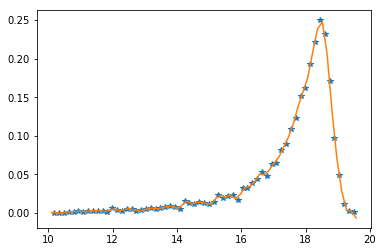

In [45]:
func_nm_b,hist_b,bins_b = surface_density(background_sample_magnitudes,Area_total_background)

%matplotlib inline
from matplotlib import pyplot as plt
from numpy import diff
b = bins_b['HAPERMAG3']
x = b[:-1] + diff(b)/2
y = hist_b['HAPERMAG3']
C = func_nm_b['HAPERMAG3']
_=plt.plot(x,y,'*',b,C.evaluate(b),'-')

#### $q(m)$

Now we have to proceed alike to get the ancillary brightness distribution.

In [46]:
ancillary_sample.head()

distances
(A, Seq) duplicates             
2360     433834423123   2.558296
2361     433834423565   0.738626
         433834423638   5.615029
2362     433836362467   6.797695
2363     433836362494   3.585183

In [47]:
N_sources_anc = len(ancillary_sample.index.droplevel(1).unique())

from astropy import units
import math
Area_radius = math.pi * rs**2
Area_radius = Area_radius.to('arcmin2')
Area_total_ancillary = Area_radius * N_sources_anc
print('Area of each individual annulus: {}'.format(Area_radius))
print('Total area covered by background sample: {}'.format(Area_total_ancillary))

Area of each individual annulus: 0.04276056667386108 arcmin2
Total area covered by background sample: 63.32839924398826 arcmin2


In [48]:
df_uk.head()

,SOURCEID,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
0,433827929919,23.367877,0.687888,NaN,NaN,2005.902151,0.022051,0.026704,0.019603,0.012745,...,18.506187,0.151259,16.839336,0.166297,17.013243,0.244477,NaN,NaN,17.544065,0.124013
1,433827929920,23.460531,0.688232,NaN,NaN,2005.902151,0.023649,0.028639,0.021024,0.013669,...,16.893356,0.035704,16.618038,0.080816,16.661270,0.118318,NaN,NaN,16.565256,0.051986
2,433827929921,23.414002,0.687667,NaN,NaN,2005.902151,0.022683,0.027469,0.020165,0.013111,...,18.633087,0.170696,17.692490,0.398679,17.692490,0.398679,NaN,NaN,17.764069,0.152736
3,433827929922,23.280570,0.687302,NaN,NaN,2005.902151,0.022506,0.027254,0.020007,0.013008,...,16.557207,0.026067,15.337543,0.038435,15.085359,0.060233,NaN,NaN,15.807901,0.025575
4,433827929923,23.474184,0.687547,NaN,NaN,2005.902151,0.023927,0.028976,0.021271,0.013830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
primary_key = ID_column_uk

acs = ancillary_sample.copy()
acs.index = ancillary_sample.index.droplevel(0).astype(df_uk[primary_key].dtype)
acs = acs.loc[~acs.index.duplicated()]

import pandas
ancillary_sample_magnitudes = pandas.merge(acs, df_uk, sort=False, how='inner',
                                               left_index=True, right_on=primary_key)
ancillary_sample_magnitudes.set_index(primary_key, inplace=True)
del acs
ancillary_sample_magnitudes.head()

,distances,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
SOURCEID,,,,,,,,,,,,,,,,,,,,,
433834423123,2.558296,14.114893,-0.352297,NaN,NaN,2006.890867,0.024134,0.029226,0.021455,0.013949,...,16.420605,0.027337,15.266109,0.031406,15.165094,0.047093,NaN,NaN,15.644726,0.019929
433834423565,0.738626,14.114795,-0.160001,NaN,NaN,2006.969972,0.021508,0.026046,0.019120,0.012431,...,18.644693,0.198955,17.770628,0.234180,17.763853,0.258605,NaN,NaN,17.884663,0.145093
433834423638,5.615029,14.116304,-0.160856,NaN,NaN,2005.768465,0.021464,0.025993,0.019082,0.012406,...,NaN,NaN,17.539215,0.210202,17.539215,0.210202,NaN,NaN,18.211197,0.195287
433836362467,6.797695,14.141094,-0.440343,NaN,NaN,2006.882247,0.024106,0.029192,0.021430,0.013933,...,17.760912,0.083793,16.968500,0.112740,16.943735,0.177616,NaN,NaN,17.142780,0.078272
433836362494,3.585183,14.154556,-0.447174,NaN,NaN,2006.882247,0.024283,0.029406,0.021587,0.014035,...,17.173470,0.049189,16.122658,0.049313,15.984794,0.066120,NaN,NaN,16.248377,0.034981


In [50]:
ancillary_sample_magnitudes.describe()

,distances,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
count,1986.000000,1986.000000,1986.000000,0.0,0.0,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,...,1320.000000,1320.000000,1545.000000,1545.000000,1545.000000,1545.000000,0.0,0.0,1547.000000,1547.000000
mean,3.253892,20.948839,-0.041642,NaN,NaN,2006.478207,0.032459,0.039308,0.028856,0.018761,...,17.211620,0.100770,16.524746,0.192030,16.493393,0.222760,NaN,NaN,16.719076,0.100069
std,1.781674,4.343018,0.290443,NaN,NaN,0.678600,0.005218,0.006319,0.004639,0.003016,...,1.863755,0.069903,1.842760,0.287458,1.859436,0.292445,NaN,NaN,1.716015,0.070200
min,0.116544,14.114795,-0.616043,NaN,NaN,2005.686836,0.021464,0.025993,0.019082,0.012406,...,10.107296,0.000458,8.269741,0.000260,8.473408,0.000292,NaN,NaN,9.577841,0.000502
25%,1.818475,17.050568,-0.295672,NaN,NaN,2005.896808,0.029166,0.035320,0.025929,0.016858,...,16.883600,0.039884,16.105494,0.065911,15.984794,0.094301,NaN,NaN,16.362699,0.040900
50%,2.959127,19.975227,-0.041050,NaN,NaN,2005.924078,0.031954,0.038697,0.028407,0.018470,...,17.848999,0.095547,17.050779,0.157007,17.000351,0.190011,NaN,NaN,17.263138,0.093453
75%,4.541647,25.234287,0.187365,NaN,NaN,2006.890888,0.034515,0.041798,0.030684,0.019950,...,18.380485,0.153957,17.632435,0.253736,17.645555,0.288566,NaN,NaN,17.791502,0.151584
max,6.998498,28.042850,0.604937,NaN,NaN,2007.731498,0.061432,0.074394,0.054613,0.035508,...,19.299809,0.346629,21.520224,9.074115,21.520224,9.074115,NaN,NaN,18.786821,0.334490


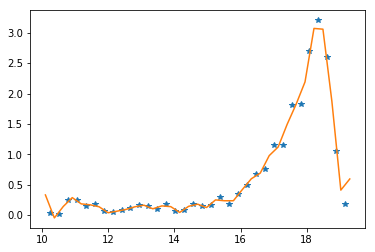

In [51]:
func_nm_a,hist_a,bins_a = surface_density(ancillary_sample_magnitudes,Area_total_ancillary)

%matplotlib inline
from matplotlib import pyplot as plt
from numpy import diff
b = bins_a['HAPERMAG3']
x = b[:-1] + diff(b)/2
y = hist_a['HAPERMAG3']
C = func_nm_a['HAPERMAG3']
_=plt.plot(x,y,'*',b,C.evaluate(b),'-')

In [52]:
Area_total_background / Area_total_ancillary

<Quantity 34.669142471303175>

In [53]:
len(background_sample.index.droplevel(1))/len(ancillary_sample.index.droplevel(1))

5.467774420946626

In [54]:
from numpy import histogram,diff
func_qm = {}
hist_diff = {}
x_diff = {}
for col in ['YAPERMAG3','J_1APERMAG3','HAPERMAG3','KAPERMAG3']:
    veca = ancillary_sample_magnitudes[col]
    vecb = background_sample_magnitudes[col]
    _min = min(veca.min(),vecb.min())
    _max = min(veca.max(),vecb.max())

    hb,bb = histogram(vecb, bins=50, range=(_min,_max))
    hb = hb/ Area_total_background

    ha,ba = histogram(veca, bins=50, range=(_min,_max))
    ha = ha/ Area_total_ancillary

    x = diff(ba)/2 + ba[:-1]

    h_diff = ha - hb
    hist_diff[col] = h_diff
    x_diff[col] = x
    func = compile_interpolation_function(x, h_diff/h_diff.sum(),normal=True)
    func_qm[col] = func
    

Q=0.183


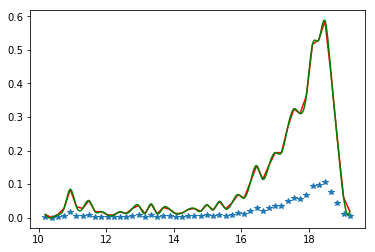

In [55]:
def plot_curve_fit(col):
    from matplotlib import pyplot as plt
    fig,ax = plt.subplots()
    from numpy import diff,linspace
    x = x_diff[col]
    xx = linspace(x.min(),x.max(),500)
    y = hist_diff[col]
    y = y/y.sum()
    C = func_qm[col]
    _=ax.plot(x,y,'*',x,C.evaluate(x),'r-',xx,C.evaluate(xx),'g-')
    print("Q={:.3f}".format(C.Q))
    
plot_curve_fit('HAPERMAG3')

Q=0.214


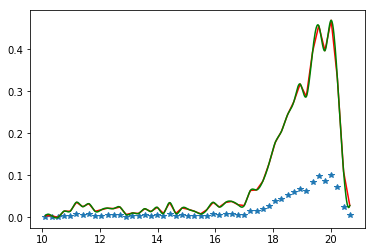

In [56]:
plot_curve_fit('YAPERMAG3')

Q=0.214


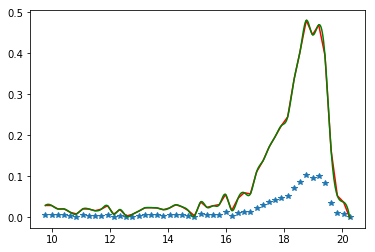

In [57]:
plot_curve_fit('J_1APERMAG3')

Q=0.184


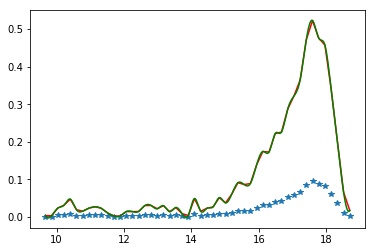

In [58]:
plot_curve_fit('KAPERMAG3')

In [59]:
for k in hist_diff.keys():
    h = hist_diff[k]
    print(h.sum())

20.18484205740928 1 / arcmin2
17.849910700360645 1 / arcmin2
18.219774839753114 1 / arcmin2
21.387055434323845 1 / arcmin2


In [60]:
col = 'KAPERMAG3'
sample = ancillary_sample_magnitudes
_min = sample[col].min()
_max = sample[col].max()
C = func_qm[col]
I = C.integrate(_min,_max)
print('Integral q(m)[{:.3f} : {:.3f}]: {}'.format(_min,_max,I))

Integral q(m)[9.578 : 18.787]: 1.0


### Define $f(r)$

$f(r)$ is defined as a bi-dimensional gaussian, where $\sigma$ is the positional error of the source and ancillary objects.

In [61]:
def define_fr(sigma_x,sigma_y):
    from cmath import sqrt,pi,exp
    sigma = sqrt(sigma_x**2 + sigma_y**2)
    f_2_pi_sigma = 1/(2 * pi * sigma)
    f_2_sigma_2 = -1/(2 * sigma**2)
    def gr(r):
        gaussian = f_2_pi_sigma * exp( r**2 * f_2_sigma_2 )
        return gaussian.real
    return gr

In [62]:
f = define_fr(2,2)

In [63]:
# f(0)

In [64]:
# f(1)

In [65]:
# f(10)

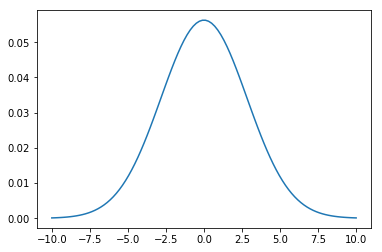

In [66]:
%matplotlib inline
import numpy
x = numpy.linspace(-10,10,100)
from matplotlib import pyplot as plt
y = [ f(r) for r in x ]
_=plt.plot(x,y,'-')

### Likelihood Ratio

Now we can compute $LR$ for all ancillary objects. The information we need to relate in a unique table is *magnitude* for each ancillary object --to be used by $q(m)$ and $n(m)$-- and *position error* from the sources table --to be used by $f(r)$.

In [67]:
ancillary_sample.head(10)

distances
(A, Seq) duplicates             
2360     433834423123   2.558296
2361     433834423565   0.738626
         433834423638   5.615029
2362     433836362467   6.797695
2363     433836362494   3.585183
2365     433832563084   5.428978
2366     433836363120   4.329322
2368     433836362527   6.895045
2369     433836363145   2.324095
2370     433834437127   4.105510

In [68]:
df_lm.set_index(ID_column_lm,inplace=True)
df_lm.head(10)

,ObsID,RAdeg,DEdeg,e_Pos,DistNN,ExtFlag,InXMM,InChandra,FSoft,e_FSoft,...,rH,F250,e_F250,F350,e_F350,F500,e_F500,XMMAO10CP,ChCP,CPCoord
Seq,,,,,,,,,,,,,,,,,,,,,
2359,742830101.0,14.097,0.166,4.7,515.8,0.0,no,no,1.61,0.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2360,742830101.0,14.115,-0.353,3.5,171.7,0.0,no,no,1.68,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2361,742830101.0,14.115,-0.160,5.8,291.7,0.0,no,no,2.02,0.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2362,742830101.0,14.142,-0.442,3.4,49.1,0.0,no,no,0.95,0.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2363,742830101.0,14.154,-0.448,2.1,49.1,0.0,no,no,7.25,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2364,742830101.0,14.162,-0.357,5.2,145.3,0.0,no,no,0.69,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2365,742830101.0,14.162,0.038,4.0,224.1,0.0,no,no,1.64,0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2366,742830101.0,14.163,-0.400,3.8,29.8,0.0,no,no,1.24,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2367,742830101.0,14.170,-0.244,2.7,283.6,0.0,no,no,0.89,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [69]:
ancillary_sample_magnitudes.sample(10)

,distances,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
SOURCEID,,,,,,,,,,,,,,,,,,,,,
433836019770,0.746982,17.318093,-0.534814,NaN,NaN,2006.882288,0.038986,0.047212,0.034659,0.022534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433828771062,1.364488,19.003348,0.362151,NaN,NaN,2006.876850,0.029718,0.035988,0.026419,0.017177,...,NaN,NaN,17.388758,0.181505,17.388758,0.181505,NaN,NaN,17.948137,0.171602
433832676448,2.058248,25.107189,0.042461,NaN,NaN,2005.896816,0.028853,0.034941,0.025650,0.016677,...,17.929939,0.096629,16.884718,0.129574,16.813383,0.141358,NaN,NaN,17.158628,0.081468
433830588187,0.940338,26.909776,0.166134,NaN,NaN,2005.924036,0.032919,0.039865,0.029265,0.019027,...,NaN,NaN,16.759869,0.171323,16.701662,0.187717,NaN,NaN,17.170341,0.106814
433836352140,6.123352,16.983057,-0.414667,NaN,NaN,2005.989634,0.038476,0.046595,0.034205,0.022239,...,18.782997,0.209874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433834460905,4.043837,27.700620,-0.299937,NaN,NaN,2005.924042,0.031768,0.038471,0.028242,0.018362,...,18.412802,0.166715,17.369020,0.211877,17.206861,0.229076,NaN,NaN,17.338112,0.108962
433834420696,6.425187,25.212197,-0.276324,NaN,NaN,2005.896818,0.030723,0.037206,0.027313,0.017758,...,17.653343,0.080364,16.416468,0.132516,16.334234,0.169916,NaN,NaN,17.044228,0.071858
433830797900,0.758633,24.715791,0.084028,NaN,NaN,2005.782085,0.037652,0.045596,0.033472,0.021763,...,NaN,NaN,17.947081,0.343615,17.947081,0.343615,NaN,NaN,18.175064,0.201067
433830642893,2.069061,26.772892,0.084565,NaN,NaN,2005.924032,0.030782,0.037278,0.027366,0.017792,...,18.204731,0.160133,16.879576,0.162226,17.045557,0.258378,NaN,NaN,17.055212,0.094585


In [70]:
_keys = ancillary_sample.index.droplevel(1).values
ancillary_sample_poserror = ancillary_sample.merge( df_lm[['e_Pos']], left_on=_keys, right_index=True )
ancillary_sample_poserror.head(10)

key_0  distances  e_Pos
(A, Seq) duplicates                          
2360     433834423123  2360   2.558296    3.5
2361     433834423565  2361   0.738626    5.8
         433834423638  2361   5.615029    5.8
2362     433836362467  2362   6.797695    3.4
2363     433836362494  2363   3.585183    2.1
2365     433832563084  2365   5.428978    4.0
2366     433836363120  2366   4.329322    3.8
2368     433836362527  2368   6.895045    4.3
2369     433836363145  2369   2.324095    4.4
2370     433834437127  2370   4.105510    3.6

In [71]:
ancillary_sample_poserror.drop('key_0',axis=1, inplace=True)

In [72]:
# we define the vector to 'join' the left table because it is using a multindex index
_keys = ancillary_sample.index.droplevel(0).values

_cols = [ c for c in df_uk.filter(like='MAG',axis=1).columns ]
ancillary_joined = ancillary_sample_poserror.merge(ancillary_sample_magnitudes[_cols], left_on=_keys, right_index=True )
ancillary_joined.head(10)

key_0  distances  e_Pos   YHALLMAG  YHALLMAGERR  \
(A, Seq) duplicates                                                             
2360     433834423123  433834423123   2.558296    3.5  17.424122     0.033594   
2361     433834423565  433834423565   0.738626    5.8        NaN          NaN   
         433834423638  433834423638   5.615029    5.8        NaN          NaN   
2362     433836362467  433836362467   6.797695    3.4  18.844223     0.132539   
2363     433836362494  433836362494   3.585183    2.1  18.274193     0.072648   
2365     433832563084  433832563084   5.428978    4.0  18.948622     0.091160   
2366     433836363120  433836363120   4.329322    3.8        NaN          NaN   
2368     433836362527  433836362527   6.895045    4.3  20.190485     0.328694   
2369     433836363145  433836363145   2.324095    4.4        NaN          NaN   
2370     433834437127  433834437127   4.105510    3.6  20.370106     0.413753   

                       YPETROMAG  YPETROMAGERR  YPSFMAG  YPSFMAGERR  \
(A, Seq) duplicates                                                   
2360     433834423123  17.339571      0.047153      NaN         NaN   
2361     433834423565        NaN           NaN      NaN         NaN   
         433834423638        NaN           NaN      NaN         NaN   
2362     433836362467  18.781025      0.171607      NaN         NaN   
2363     433836362494  18.210474      0.095541      NaN         NaN   
2365     433832563084  18.862259      0.121492      NaN         NaN   
2366     433836363120        NaN           NaN      NaN         NaN   
2368     433836362527  20.190479      0.328940      NaN         NaN   
2369     433836363145        NaN           NaN      NaN         NaN   
2370     433834437127  20.370106      0.413753      NaN         NaN   

                       YAPERMAG3      ...       HAPERMAG3  HAPERMAG3ERR  \
(A, Seq) duplicates                   ...                                 
2360     433834423123  17.924706      ...       16.420605      0.027337   
2361     433834423565        NaN      ...       18.644693      0.198955   
         433834423638        NaN      ...             NaN           NaN   
2362     433836362467  18.888762      ...       17.760912      0.083793   
2363     433836362494  18.222660      ...       17.173470      0.049189   
2365     433832563084  18.878496      ...       17.777243      0.096601   
2366     433836363120        NaN      ...             NaN           NaN   
2368     433836362527  20.279314      ...       18.432409      0.153373   
2369     433836363145        NaN      ...             NaN           NaN   
2370     433834437127  20.141270      ...             NaN           NaN   

                        KHALLMAG  KHALLMAGERR  KPETROMAG  KPETROMAGERR  \
(A, Seq) duplicates                                                      
2360     433834423123  15.266109     0.031406  15.165094      0.047093   
2361     433834423565  17.770628     0.234180  17.763853      0.258605   
         433834423638  17.539215     0.210202  17.539215      0.210202   
2362     433836362467  16.968500     0.112740  16.943735      0.177616   
2363     433836362494  16.122658     0.049313  15.984794      0.066120   
2365     433832563084  17.553614     0.169763  17.494886      0.185832   
2366     433836363120  17.838139     0.317437  17.724998      0.303445   
2368     433836362527  17.352652     0.137550  17.437912      0.219109   
2369     433836363145  17.910995     0.299177  17.910995      0.299177   
2370     433834437127  18.955881     0.764128  18.777044      0.610249   

                       KPSFMAG  KPSFMAGERR  KAPERMAG3  KAPERMAG3ERR  
(A, Seq) duplicates                                                  
2360     433834423123      NaN         NaN  15.644726      0.019929  
2361     433834423565      NaN         NaN  17.884663      0.145093  
         433834423638      NaN         NaN  18.211197      0.195287  
2362     433836362467      NaN         NaN  17.142780      0.078

In [73]:
ancillary_joined.drop('key_0',axis=1,inplace=True)

In [74]:
e_pos = ancillary_joined['e_Pos'].mean()
print(e_pos)

2.82870090634


In [75]:
def define_LR(func_qm, func_fr, func_nm):
    def LR(r,m, qm=func_qm, fr=func_fr, nm=func_nm):
        return qm(m)*fr(r)/nm(m)
    return LR

In [76]:
func_fr = define_fr(e_pos,e_pos)

df = ancillary_joined.copy()

for mag_col in 'YAPERMAG3 J_1APERMAG3 HAPERMAG3 KAPERMAG3'.split():
    
    LR = define_LR(func_qm=func_qm[mag_col].evaluate, func_fr=func_fr, func_nm=func_nm_b[col].evaluate)
    
    colname = 'LR_{}'.format(mag_col)
    df[colname] = ancillary_joined.apply(lambda df:LR(df['e_Pos'],df[mag_col]), axis=1)

In [77]:
df.head(10)

distances  e_Pos   YHALLMAG  YHALLMAGERR  YPETROMAG  \
(A, Seq) duplicates                                                          
2360     433834423123   2.558296    3.5  17.424122     0.033594  17.339571   
2361     433834423565   0.738626    5.8        NaN          NaN        NaN   
         433834423638   5.615029    5.8        NaN          NaN        NaN   
2362     433836362467   6.797695    3.4  18.844223     0.132539  18.781025   
2363     433836362494   3.585183    2.1  18.274193     0.072648  18.210474   
2365     433832563084   5.428978    4.0  18.948622     0.091160  18.862259   
2366     433836363120   4.329322    3.8        NaN          NaN        NaN   
2368     433836362527   6.895045    4.3  20.190485     0.328694  20.190479   
2369     433836363145   2.324095    4.4        NaN          NaN        NaN   
2370     433834437127   4.105510    3.6  20.370106     0.413753  20.370106   

                       YPETROMAGERR  YPSFMAG  YPSFMAGERR  YAPERMAG3  \
(A, Seq) duplicates                                                   
2360     433834423123      0.047153      NaN         NaN  17.924706   
2361     433834423565           NaN      NaN         NaN        NaN   
         433834423638           NaN      NaN         NaN        NaN   
2362     433836362467      0.171607      NaN         NaN  18.888762   
2363     433836362494      0.095541      NaN         NaN  18.222660   
2365     433832563084      0.121492      NaN         NaN  18.878496   
2366     433836363120           NaN      NaN         NaN        NaN   
2368     433836362527      0.328940      NaN         NaN  20.279314   
2369     433836363145           NaN      NaN         NaN        NaN   
2370     433834437127      0.413753      NaN         NaN  20.141270   

                       YAPERMAG3ERR      ...       KPETROMAG  KPETROMAGERR  \
(A, Seq) duplicates                      ...                                 
2360     433834423123      0.023942      ...       15.165094      0.047093   
2361     433834423565           NaN      ...       17.763853      0.258605   
         433834423638           NaN      ...       17.539215      0.210202   
2362     433836362467      0.070068      ...       16.943735      0.177616   
2363     433836362494      0.039503      ...       15.984794      0.066120   
2365     433832563084      0.053765      ...       17.494886      0.185832   
2366     433836363120           NaN      ...       17.724998      0.303445   
2368     433836362527      0.241452      ...       17.437912      0.219109   
2369     433836363145           NaN      ...       17.910995      0.299177   
2370     433834437127      0.159393      ...       18.777044      0.610249   

                       KPSFMAG  KPSFMAGERR  KAPERMAG3  KAPERMAG3ERR  \
(A, Seq) duplicates                                                   
2360     433834423123      NaN         NaN  15.644726      0.019929   
2361     433834423565      NaN         NaN  17.884663      0.145093   
         433834423638      NaN         NaN  18.211197      0.195287   
2362     433836362467      NaN         NaN  17.142780      0.078272   
2363     433836362494      NaN         NaN  16.248377      0.034981   
2365     433832563084      NaN         NaN  17.446341      0.103341   
2366     433836363120      NaN         NaN  18.112112      0.189446   
2368     433836362527      NaN         NaN  17.248894      0.086354   
2369     433836363145      NaN         NaN  18.370745      0.240838   
2370     433834437127      NaN         NaN  18.318068      0.225548   

                       LR_YAPERMAG3  LR_J_1APERMAG3  LR_HAPERMAG3  \
(A, Seq) duplicates                                                 
2360     433834423123      0.015332        0.028080      0.071227   
2361     433834423565           NaN       -0.005289      0.843252   
         433834423638           NaN             NaN           NaN   
2362     433836362467     -2.800060        0.177738      0.035366   
2363     433836362494      0.

In [78]:
Q = 1

bla = df.copy()
for mag_col in 'YAPERMAG3 J_1APERMAG3 HAPERMAG3 KAPERMAG3'.split():
    lr_col = 'LR_{}'.format(mag_col)
    r_col = 'R_{}'.format(mag_col)
    bla[r_col] = df.groupby(level=0)[lr_col].apply(lambda s:s/s.sum())

In [79]:
bla.head(20)

distances  e_Pos   YHALLMAG  YHALLMAGERR  YPETROMAG  \
(A, Seq) duplicates                                                          
2360     433834423123   2.558296    3.5  17.424122     0.033594  17.339571   
2361     433834423565   0.738626    5.8        NaN          NaN        NaN   
         433834423638   5.615029    5.8        NaN          NaN        NaN   
2362     433836362467   6.797695    3.4  18.844223     0.132539  18.781025   
2363     433836362494   3.585183    2.1  18.274193     0.072648  18.210474   
2365     433832563084   5.428978    4.0  18.948622     0.091160  18.862259   
2366     433836363120   4.329322    3.8        NaN          NaN        NaN   
2368     433836362527   6.895045    4.3  20.190485     0.328694  20.190479   
2369     433836363145   2.324095    4.4        NaN          NaN        NaN   
2370     433834437127   4.105510    3.6  20.370106     0.413753  20.370106   
2371     433836363155   2.352554    3.4        NaN          NaN        NaN   
2372     433829058905   2.172553    4.7  20.290100     0.246336  20.290100   
2373     433832563245   2.146502    1.3  18.332699     0.063843  18.261703   
2374     433832563006   2.928150    3.4  20.211857     0.379707  20.234011   
         433832563005   5.038435    3.4  19.264446     0.171967  19.245205   
2375     433836363033   0.898566    3.1        NaN          NaN        NaN   
2377     433830897005   1.941389    2.9  19.524969     0.182216  19.526970   
2378     433832563193   3.424471    4.6  16.337986     0.018466  16.166098   
         433832563562   5.528915    4.6        NaN          NaN        NaN   
2379     433834437256   0.640801    1.6  19.390974     0.183926  19.395226   

                       YPETROMAGERR  YPSFMAG  YPSFMAGERR  YAPERMAG3  \
(A, Seq) duplicates                                                   
2360     433834423123      0.047153      NaN         NaN  17.924706   
2361     433834423565           NaN      NaN         NaN        NaN   
         433834423638           NaN      NaN         NaN        NaN   
2362     433836362467      0.171607      NaN         NaN  18.888762   
2363     433836362494      0.095541      NaN         NaN  18.222660   
2365     433832563084      0.121492      NaN         NaN  18.878496   
2366     433836363120           NaN      NaN         NaN        NaN   
2368     433836362527      0.328940      NaN         NaN  20.279314   
2369     433836363145           NaN      NaN         NaN        NaN   
2370     433834437127      0.413753      NaN         NaN  20.141270   
2371     433836363155           NaN      NaN         NaN        NaN   
2372     433829058905      0.246336      NaN         NaN  20.627474   
2373     433832563245      0.090970      NaN         NaN  18.467182   
2374     433832563006      0.376071      NaN         NaN  20.095844   
         433832563005      0.206013      NaN         NaN  19.307280   
2375     433836363033           NaN      NaN         NaN        NaN   
2377     433830897005      0.197271      NaN         NaN  20.111305   
2378     433832563193      0.023612      NaN         NaN  17.243748   
         433832563562           NaN      NaN         NaN        NaN   
2379     433834437256      0.193301      NaN         NaN  19.261967   

                       YAPERMAG3ERR     ...       KAPERMAG3  KAPERMAG3ERR  \
(A, Seq) duplicates                     ...                                 
2360     433834423123      0.023942     ...       15.644726      0.019929   
2361     433834423565           NaN     ...       17.884663      0.145093   
         433834423638           NaN     ...       18.211197      0.195287   
2362     433836362467      0.070068     ...       17.142780      0.078272   
2363     433836362494      0.039503     ...       16.248377      0.034981   
2365     433832563084      0.053765     ...       17.446341      0.103341   
2366     433836363120           NaN     ...       18.112112      0.189446   
2368     433836362527      0.241452     ...       

In [80]:
final_matches_perMag = {}
for mag_col in 'YAPERMAG3 J_1APERMAG3 HAPERMAG3 KAPERMAG3'.split():
    r_col = 'R_{}'.format(mag_col)
    temp_df = bla.filter(like=mag_col, axis=1)
    mask = temp_df.groupby(level=0)[r_col].apply(lambda x:x==x.max())
    final_matches_perMag[mag_col] = temp_df.loc[mask]


In [81]:
for c in final_matches_perMag.keys():
    print(final_matches_perMag[c])

                       YAPERMAG3  YAPERMAG3ERR  LR_YAPERMAG3  R_YAPERMAG3
(A, Seq) duplicates                                                      
2360     433834423123  17.924706      0.023942      0.015332     1.000000
2362     433836362467  18.888762      0.070068     -2.800060     1.000000
2363     433836362494  18.222660      0.039503      0.046278     1.000000
2365     433832563084  18.878496      0.053765     -4.183243     1.000000
2368     433836362527  20.279314      0.241452     -0.000918     1.000000
2370     433834437127  20.141270      0.159393     -0.002145     1.000000
2372     433829058905  20.627474      0.219280     -0.000037     1.000000
2373     433832563245  18.467182      0.038477      0.226794     1.000000
2374     433832563005  19.307280      0.076326     -0.028681     0.915217
2377     433830897005  20.111305      0.142833     -0.002775     1.000000
2378     433832563193  17.243748      0.015382      0.010406     1.000000
2379     433834437256  19.261967      

In [82]:
col = 'YAPERMAG3'
mle_match = final_matches_perMag[col]
for col in 'J_1APERMAG3 HAPERMAG3 KAPERMAG3'.split():
    tab = final_matches_perMag[col]
    mle_match = mle_match.merge(tab, how='outer', left_index=True, right_index=True)

In [83]:
mle_match.head(20)

YAPERMAG3  YAPERMAG3ERR  LR_YAPERMAG3  R_YAPERMAG3  \
(A, Seq) duplicates                                                         
2360     433834423123  17.924706      0.023942      0.015332     1.000000   
2361     433834423565        NaN           NaN           NaN          NaN   
         433834423638        NaN           NaN           NaN          NaN   
2362     433836362467  18.888762      0.070068     -2.800060     1.000000   
2363     433836362494  18.222660      0.039503      0.046278     1.000000   
2365     433832563084  18.878496      0.053765     -4.183243     1.000000   
2366     433836363120        NaN           NaN           NaN          NaN   
2368     433836362527  20.279314      0.241452     -0.000918     1.000000   
2369     433836363145        NaN           NaN           NaN          NaN   
2370     433834437127  20.141270      0.159393     -0.002145     1.000000   
2371     433836363155        NaN           NaN           NaN          NaN   
2372     433829058905  20.627474      0.219280     -0.000037     1.000000   
2373     433832563245  18.467182      0.038477      0.226794     1.000000   
2374     433832563005  19.307280      0.076326     -0.028681     0.915217   
2375     433836363033        NaN           NaN           NaN          NaN   
2377     433830897005  20.111305      0.142833     -0.002775     1.000000   
2378     433832563193  17.243748      0.015382      0.010406     1.000000   
         433832563562        NaN           NaN           NaN          NaN   
2379     433834437256  19.261967      0.074662     -0.045075     1.000000   
2380     433836362941        NaN           NaN           NaN          NaN   

                       J_1APERMAG3  J_1APERMAG3ERR  LR_J_1APERMAG3  \
(A, Seq) duplicates                                                  
2360     433834423123    17.245426        0.019872        0.028080   
2361     433834423565    19.491657        0.146564       -0.005289   
         433834423638          NaN             NaN             NaN   
2362     433836362467    18.414364        0.067330        0.177738   
2363     433836362494    17.871763        0.041378        0.029622   
2365     433832563084    18.501507        0.062208        0.311976   
2366     433836363120          NaN             NaN             NaN   
2368     433836362527    19.435019        0.169515       -0.012953   
2369     433836363145          NaN             NaN             NaN   
2370     433834437127          NaN             NaN             NaN   
2371     433836363155          NaN             NaN             NaN   
2372     433829058905    19.613602        0.154692       -0.002648   
2373     433832563245    18.165794        0.046680        0.053318   
2374     433832563005    19.322327        0.131315       -0.033419   
2375     433836363033          NaN             NaN             NaN   
2377     433830897005          NaN             NaN             NaN   
2378     433832563193          NaN             NaN             NaN   
         433832563562    18.779383        0.081248        2.367595   
2379     433834437256    18.953220        0.094430       -1.037225   
2380     433836362941    19.408398        0.167378       -0.020944   

                       R_J_1APERMAG3  HAPERMAG3  HAPERMAG3ERR  LR_HAPERMAG3  \
(A, Seq) duplicates                                                           
2360     433834423123       1.000000  16.420605      0.027337      0.071227   
2361     433834423565       1.000000  18.644693      0.198955      0.843252   
         433834423638            NaN        NaN           NaN           NaN   
2362     433836362467       1.000000  17.760912      0.083793      0.035366   
2363     433836362494       1.000000  17.173470      0.049189      0.055195   
2365     433832563084       1.000000  17.777243      0.096601      0.030268   
2366     433836363120            NaN        NaN           NaN           NaN   
2368     433836362527       1.000000  18.432409      0.153373      0.260244 

In [84]:
temp_df = mle_match.filter(regex="^R_", axis=1)

mask = temp_df.agg('sum',axis=1).groupby(level=0).apply(lambda x:x==x.max())

mle_match_final = mle_match.loc[mask]
mle_match_final.head(10)

,,YAPERMAG3,YAPERMAG3ERR,LR_YAPERMAG3,R_YAPERMAG3,J_1APERMAG3,J_1APERMAG3ERR,LR_J_1APERMAG3,R_J_1APERMAG3,HAPERMAG3,HAPERMAG3ERR,LR_HAPERMAG3,R_HAPERMAG3,KAPERMAG3,KAPERMAG3ERR,LR_KAPERMAG3,R_KAPERMAG3
"(A, Seq)",duplicates,,,,,,,,,,,,,,,,
2360,433834423123,17.924706,0.023942,0.015332,1.0,17.245426,0.019872,0.028080,1.0,16.420605,0.027337,0.071227,1.0,15.644726,0.019929,0.081955,1.0
2361,433834423565,NaN,NaN,NaN,NaN,19.491657,0.146564,-0.005289,1.0,18.644693,0.198955,0.843252,1.0,NaN,NaN,NaN,NaN
2362,433836362467,18.888762,0.070068,-2.800060,1.0,18.414364,0.067330,0.177738,1.0,17.760912,0.083793,0.035366,1.0,17.142780,0.078272,0.077586,1.0
2363,433836362494,18.222660,0.039503,0.046278,1.0,17.871763,0.041378,0.029622,1.0,17.173470,0.049189,0.055195,1.0,16.248377,0.034981,0.110417,1.0
2365,433832563084,18.878496,0.053765,-4.183243,1.0,18.501507,0.062208,0.311976,1.0,17.777243,0.096601,0.030268,1.0,17.446341,0.103341,0.069000,1.0
2366,433836363120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.112112,0.189446,0.042469,1.0
2368,433836362527,20.279314,0.241452,-0.000918,1.0,19.435019,0.169515,-0.012953,1.0,18.432409,0.153373,0.260244,1.0,17.248894,0.086354,0.064378,1.0
2369,433836363145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.370745,0.240838,0.050331,1.0
2370,433834437127,20.141270,0.159393,-0.002145,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.318068,0.225548,0.058400,1.0


In [85]:
mle_match_reliability = mle_match_final.filter(like='R_',axis=1)
mle_match_reliability.head(10)

,,LR_YAPERMAG3,R_YAPERMAG3,LR_J_1APERMAG3,R_J_1APERMAG3,LR_HAPERMAG3,R_HAPERMAG3,LR_KAPERMAG3,R_KAPERMAG3
"(A, Seq)",duplicates,,,,,,,,
2360,433834423123,0.015332,1.0,0.028080,1.0,0.071227,1.0,0.081955,1.0
2361,433834423565,NaN,NaN,-0.005289,1.0,0.843252,1.0,NaN,NaN
2362,433836362467,-2.800060,1.0,0.177738,1.0,0.035366,1.0,0.077586,1.0
2363,433836362494,0.046278,1.0,0.029622,1.0,0.055195,1.0,0.110417,1.0
2365,433832563084,-4.183243,1.0,0.311976,1.0,0.030268,1.0,0.069000,1.0
2366,433836363120,NaN,NaN,NaN,NaN,NaN,NaN,0.042469,1.0
2368,433836362527,-0.000918,1.0,-0.012953,1.0,0.260244,1.0,0.064378,1.0
2369,433836363145,NaN,NaN,NaN,NaN,NaN,NaN,0.050331,1.0
2370,433834437127,-0.002145,1.0,NaN,NaN,NaN,NaN,0.058400,1.0


In [86]:
df_lm.head()

,ObsID,RAdeg,DEdeg,e_Pos,DistNN,ExtFlag,InXMM,InChandra,FSoft,e_FSoft,...,rH,F250,e_F250,F350,e_F350,F500,e_F500,XMMAO10CP,ChCP,CPCoord
Seq,,,,,,,,,,,,,,,,,,,,,
2359,742830101.0,14.097,0.166,4.7,515.8,0.0,no,no,1.61,0.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2360,742830101.0,14.115,-0.353,3.5,171.7,0.0,no,no,1.68,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2361,742830101.0,14.115,-0.160,5.8,291.7,0.0,no,no,2.02,0.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2362,742830101.0,14.142,-0.442,3.4,49.1,0.0,no,no,0.95,0.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2363,742830101.0,14.154,-0.448,2.1,49.1,0.0,no,no,7.25,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [87]:
# cat_lm.set_index('Seq', inplace=True)
match_mle_a = df_lm.loc[mle_match_reliability.index.droplevel(1).values]

In [88]:
df_uk.head()

,SOURCEID,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
0,433827929919,23.367877,0.687888,NaN,NaN,2005.902151,0.022051,0.026704,0.019603,0.012745,...,18.506187,0.151259,16.839336,0.166297,17.013243,0.244477,NaN,NaN,17.544065,0.124013
1,433827929920,23.460531,0.688232,NaN,NaN,2005.902151,0.023649,0.028639,0.021024,0.013669,...,16.893356,0.035704,16.618038,0.080816,16.661270,0.118318,NaN,NaN,16.565256,0.051986
2,433827929921,23.414002,0.687667,NaN,NaN,2005.902151,0.022683,0.027469,0.020165,0.013111,...,18.633087,0.170696,17.692490,0.398679,17.692490,0.398679,NaN,NaN,17.764069,0.152736
3,433827929922,23.280570,0.687302,NaN,NaN,2005.902151,0.022506,0.027254,0.020007,0.013008,...,16.557207,0.026067,15.337543,0.038435,15.085359,0.060233,NaN,NaN,15.807901,0.025575
4,433827929923,23.474184,0.687547,NaN,NaN,2005.902151,0.023927,0.028976,0.021271,0.013830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
df_uk.set_index('SOURCEID', inplace=True)
match_mle_b = df_uk.loc[mle_match_reliability.index.droplevel(0).values]

In [90]:
match_mle_a.head()

,ObsID,RAdeg,DEdeg,e_Pos,DistNN,ExtFlag,InXMM,InChandra,FSoft,e_FSoft,...,rH,F250,e_F250,F350,e_F350,F500,e_F500,XMMAO10CP,ChCP,CPCoord
Seq,,,,,,,,,,,,,,,,,,,,,
2360,742830101.0,14.115,-0.353,3.5,171.7,0.0,no,no,1.68,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2361,742830101.0,14.115,-0.160,5.8,291.7,0.0,no,no,2.02,0.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2362,742830101.0,14.142,-0.442,3.4,49.1,0.0,no,no,0.95,0.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2363,742830101.0,14.154,-0.448,2.1,49.1,0.0,no,no,7.25,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2365,742830101.0,14.162,0.038,4.0,224.1,0.0,no,no,1.64,0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [91]:
match_mle_b.head()

,RA,DEC,SIGRA,SIGDEC,EPOCH,EBV,AY,AJ,AH,AK,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
SOURCEID,,,,,,,,,,,,,,,,,,,,,
433834423123,14.114893,-0.352297,NaN,NaN,2006.890867,0.024134,0.029226,0.021455,0.013949,0.008688,...,16.420605,0.027337,15.266109,0.031406,15.165094,0.047093,NaN,NaN,15.644726,0.019929
433834423565,14.114795,-0.160001,NaN,NaN,2006.969972,0.021508,0.026046,0.019120,0.012431,0.007743,...,18.644693,0.198955,17.770628,0.234180,17.763853,0.258605,NaN,NaN,17.884663,0.145093
433836362467,14.141094,-0.440343,NaN,NaN,2006.882247,0.024106,0.029192,0.021430,0.013933,0.008678,...,17.760912,0.083793,16.968500,0.112740,16.943735,0.177616,NaN,NaN,17.142780,0.078272
433836362494,14.154556,-0.447174,NaN,NaN,2006.882247,0.024283,0.029406,0.021587,0.014035,0.008742,...,17.173470,0.049189,16.122658,0.049313,15.984794,0.066120,NaN,NaN,16.248377,0.034981
433832563084,14.162007,0.039508,NaN,NaN,2006.890863,0.025553,0.030945,0.022717,0.014770,0.009199,...,17.777243,0.096601,17.553614,0.169763,17.494886,0.185832,NaN,NaN,17.446341,0.103341


In [92]:
final_mle_match = pandas.concat([ match_mle_a.reset_index(), match_mle_b.reset_index()], axis=1).set_index([ID_column_lm,ID_column_uk])

In [93]:
final_mle_match.head()

,,ObsID,RAdeg,DEdeg,e_Pos,DistNN,ExtFlag,InXMM,InChandra,FSoft,e_FSoft,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
Seq,SOURCEID,,,,,,,,,,,,,,,,,,,,,
2360,433834423123,742830101.0,14.115,-0.353,3.5,171.7,0.0,no,no,1.68,0.38,...,16.420605,0.027337,15.266109,0.031406,15.165094,0.047093,NaN,NaN,15.644726,0.019929
2361,433834423565,742830101.0,14.115,-0.160,5.8,291.7,0.0,no,no,2.02,0.50,...,18.644693,0.198955,17.770628,0.234180,17.763853,0.258605,NaN,NaN,17.884663,0.145093
2362,433836362467,742830101.0,14.142,-0.442,3.4,49.1,0.0,no,no,0.95,0.26,...,17.760912,0.083793,16.968500,0.112740,16.943735,0.177616,NaN,NaN,17.142780,0.078272
2363,433836362494,742830101.0,14.154,-0.448,2.1,49.1,0.0,no,no,7.25,0.63,...,17.173470,0.049189,16.122658,0.049313,15.984794,0.066120,NaN,NaN,16.248377,0.034981
2365,433832563084,742830101.0,14.162,0.038,4.0,224.1,0.0,no,no,1.64,0.44,...,17.777243,0.096601,17.553614,0.169763,17.494886,0.185832,NaN,NaN,17.446341,0.103341


In [94]:
final_mle_match.tail()

,,ObsID,RAdeg,DEdeg,e_Pos,DistNN,ExtFlag,InXMM,InChandra,FSoft,e_FSoft,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
Seq,SOURCEID,,,,,,,,,,,,,,,,,,,,,
5213,433832462768,747440101.0,27.994,0.063,3.3,138.7,0.0,no,no,0.99,0.26,...,17.786472,0.099437,16.651016,0.118230,16.779015,0.213026,NaN,NaN,16.925835,0.074258
5215,433836104605,747440101.0,28.000,-0.415,2.5,174.1,0.0,no,no,1.15,0.25,...,13.036633,0.002181,12.830576,0.003338,12.822956,0.003539,NaN,NaN,12.797623,0.002469
5217,433836104787,747440101.0,28.007,-0.463,3.5,141.3,0.0,no,no,0.77,0.25,...,18.339977,0.154737,17.724470,0.259511,17.860441,0.402296,NaN,NaN,17.639168,0.117859
5219,433834205134,747440101.0,28.024,-0.263,3.1,242.2,0.0,no,no,0.85,0.25,...,18.424446,0.180232,17.181353,0.245283,17.160769,0.228786,NaN,NaN,17.618818,0.149170
5220,433830737812,747440101.0,28.044,0.134,4.1,167.0,0.0,no,no,0.79,0.22,...,17.293871,0.057284,15.975023,0.099189,16.141174,0.182109,NaN,NaN,16.625101,0.057040


In [95]:
final_mle_match.sample(5)

,,ObsID,RAdeg,DEdeg,e_Pos,DistNN,ExtFlag,InXMM,InChandra,FSoft,e_FSoft,...,HAPERMAG3,HAPERMAG3ERR,KHALLMAG,KHALLMAGERR,KPETROMAG,KPETROMAGERR,KPSFMAG,KPSFMAGERR,KAPERMAG3,KAPERMAG3ERR
Seq,SOURCEID,,,,,,,,,,,,,,,,,,,,,
3054,433830832449,747390101.0,17.034,0.077,3.7,66.1,0.0,no,no,0.38,0.10,...,18.645838,0.203443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3629,433828292717,747400101.0,19.402,0.562,2.3,86.3,0.0,no,no,3.07,0.44,...,NaN,NaN,18.317797,0.312936,18.156382,0.351777,NaN,NaN,18.165691,0.184878
2817,433832583778,742830101.0,15.938,-0.121,2.9,193.3,0.0,no,no,1.53,0.24,...,18.212225,0.149940,17.668640,0.176986,17.776709,0.286265,NaN,NaN,17.455675,0.101515
3574,433834318228,747400101.0,19.210,-0.307,1.7,76.1,0.0,no,no,2.28,0.22,...,17.596136,0.060489,16.403347,0.086130,16.509922,0.160516,NaN,NaN,16.863695,0.051403
2635,433830901006,742830101.0,15.247,0.205,2.1,214.9,0.0,no,no,1.72,0.19,...,17.111403,0.049267,16.229816,0.059616,16.244713,0.088863,NaN,NaN,16.150557,0.033153


In [96]:
final_mle_match.describe()

               ObsID        RAdeg        DEdeg        e_Pos       DistNN  \
count   1.492000e+03  1492.000000  1492.000000  1492.000000  1492.000000   
unique           NaN          NaN          NaN          NaN          NaN   
top              NaN          NaN          NaN          NaN          NaN   
freq             NaN          NaN          NaN          NaN          NaN   
mean    7.465153e+08    20.871196    -0.035375     2.842091   127.074665   
std     1.822402e+06     4.348811     0.287653     0.906100    79.624401   
min     7.428301e+08    14.115000    -0.617000     0.400000    16.400000   
25%     7.473901e+08    17.036250    -0.282250     2.300000    72.700000   
50%     7.474001e+08    19.875000    -0.027500     2.800000   112.600000   
75%     7.474301e+08    25.142750     0.189000     3.400000   162.875000   
max     7.474401e+08    28.044000     0.604000     7.300000   765.400000   

            ExtFlag InXMM InChandra        FSoft      e_FSoft      ...       \
count   

In [97]:
RA_diff = final_mle_match['RAdeg'] - final_mle_match['RA']
RA_diff.describe()

count    1492.000000
mean       -0.000087
std         0.000646
min        -0.001874
25%        -0.000508
50%        -0.000090
75%         0.000295
max         0.001933
dtype: float64

Total number of rows: 1492 (1.5e+03)

-> Has Nil? (How many?)
0 (0.000%)


In [98]:
DEC_diff = final_mle_match['DEdeg'] - final_mle_match['DEC']
DEC_diff.describe()

count    1492.000000
mean       -0.000126
std         0.000637
min        -0.001886
25%        -0.000537
50%        -0.000134
75%         0.000265
max         0.001909
dtype: float64

Total number of rows: 1492 (1.5e+03)

-> Has Nil? (How many?)
0 (0.000%)


In [99]:
final_mle_match.to_csv('lamassa_ukidss_MatchMLE.csv')

# Plot samples

## ancillary *vs* background

Trying to find the difference between them...

In [ ]:
_ = plot_distros('KAPERMAG3')

In [ ]:
_ = plot_distros('J_1APERMAG3')

In [ ]:
_ = plot_distros('YAPERMAG3')

In [ ]:
_ = plot_distros('HAPERMAG3')

In [ ]:
from booq.plot import PlotHisto
p = PlotHisto()
# for col in ['YAPERMAG3','J_1APERMAG3','HAPERMAG3','KAPERMAG3']:
#     ds_label = p.add_dataset(cat_uk_sample,label=col,x=col)
#     p.plot(ds_label)
col = 'KAPERMAG3'
dsl = p.add_dataset(background_sample_magnitudes, label='background',x=col)
p.plot(dsl)
dsl = p.add_dataset(ancillary_sample_magnitudes, label='ancillary', x=col)
p.plot(dsl)
p.show()

In [ ]:
def plot_colors(col1,col2,col3):
    from booq import plot
    p = plot.PlotScatter()

    bkg_12 = background_sample_magnitudes[col1] - background_sample_magnitudes[col2]
    bkg_23 = background_sample_magnitudes[col2] - background_sample_magnitudes[col3]

    anc_12 = ancillary_sample_magnitudes[col1] - ancillary_sample_magnitudes[col2]
    anc_23 = ancillary_sample_magnitudes[col2] - ancillary_sample_magnitudes[col3]


    db = {12:bkg_12.values, 23:bkg_23.values}
    dsl = p.add_dataset(db, label='bkg', x=12, y=23)
    p.plot(dsl)

    da = {12:anc_12.values, 23:anc_23.values}
    dsl = p.add_dataset(da, label='anc', x=12, y=23)
    p.plot(dsl)

    p.show()
    
plot_colors('YAPERMAG3','J_1APERMAG3','HAPERMAG3')

In [ ]:
plot_colors('J_1APERMAG3','HAPERMAG3','KAPERMAG3')

In [ ]:
def plot_grid_scatter(cols):
    dfb = background_sample_magnitudes[cols]
    dfb['sample'] = 'background'

    dfa = ancillary_sample_magnitudes[cols]
    dfa['sample'] = 'ancillary'

    df = dfb.append(dfa)

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    g = sns.PairGrid(df, hue="sample")
#     try:
    gg = g.map_diag(sns.kdeplot)
    gg = gg.map_offdiag(plt.scatter)
#     except:
#         gg = g.map(plt.scatter)
    g = gg.add_legend()

plot_grid_scatter(['YAPERMAG3','J_1APERMAG3','HAPERMAG3','KAPERMAG3'])

In [ ]:
ancillary_sample_magnitudes.columns

In [ ]:
cols = ['YHALLMAG','YPETROMAG','YAPERMAG3']
plot_grid_scatter(cols)

In [ ]:
cols = ['J_1HALLMAG','J_1PETROMAG','J_1APERMAG3']
plot_grid_scatter(cols)

In [ ]:
cols = ['HHALLMAG','HPETROMAG','HAPERMAG3']
plot_grid_scatter(cols)

In [ ]:
cols = ['KHALLMAG','KPETROMAG','KAPERMAG3']
plot_grid_scatter(cols)

In [ ]:
bkg_ratio_PetroHall_K = background_sample_magnitudes['KPETROMAG']/background_sample_magnitudes['KHALLMAG']
anc_ratio_PetroHall_K = ancillary_sample_magnitudes['KPETROMAG']/ancillary_sample_magnitudes['KHALLMAG']
d = {'bkg':bkg_ratio_PetroHall_K, 'anc':anc_ratio_PetroHall_K}

from booq.plot import PlotHisto
p = PlotHisto()
dsl = p.add_dataset(d, label='background',x='bkg')
p.plot(dsl)
dsl = p.add_dataset(d, label='ancillary', x='anc')
p.plot(dsl)
p.show()

In [ ]:
def cdf(vec,bins):
    import numpy as np
    h,b = np.histogram(vec,bins=bins)
    cdf = np.cumsum(h)
    cdf = cdf/cdf.sum()
    return cdf,h
def ks_test(vec1,vec2):
    import numpy as np
    vmin = min(vec1.min(),vec2.min())
    vmax = max(vec1.max(),vec2.max())
    bins = np.linspace(vmin,vmax,50)
    cdf1,h1 = cdf(vec1,bins)
    cdf2,h2 = cdf(vec2,bins)
    assert len(cdf1)==len(cdf2)
    dist = 0
    dist_i = None
    for i in range(len(cdf1)):
        diff = abs(cdf1[i]-cdf2[i])
        if diff > dist:
            dist = diff
            dist_i = i
    i = dist_i
    
    from matplotlib import pyplot as plt
    fig,ax = plt.subplots()
    x = bins[:-1] + np.diff(bins)/2
    ax.plot(x,cdf1,'b-')
    ax.plot(x,cdf2,'r-')
    test_x = [x[i],x[i]]
    _my = min(cdf1[i],cdf2[i])
    test_y = [_my, (dist+_my)]
    ax.plot(test_x,test_y,'g-')
    return dist,h1.sum(),h2.sum()

df = DataFrame(d)
vec1 = df['bkg'].dropna()
vec2 = df['anc'].dropna()
ks_dist,n1,n2 = ks_test(vec1,vec2)
print('KS distance: {}'.format(ks_dist))
print('Number of points, vec1: {}'.format(n1))
print('Number of points, vec2: {}'.format(n2))

In [ ]:
df = DataFrame(d)
vec1 = df['bkg'].dropna()
vec2 = df['anc'].dropna()
ks_dist,n1,n2 = ks_test(vec1,vec2)
print('KS distance: {}'.format(ks_dist))
print('Number of points, vec1: {}'.format(n1))
print('Number of points, vec2: {}'.format(n2))